# Imports

In [1]:
import os
import sys
import datetime
import gc
import numpy as np

import pandas as pd

import string
import re
import matplotlib.pyplot as plt
import math
from matplotlib import rc
import random

import plotly.express as px 
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')


from IPython.display import Audio, display

def allDone():
  display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))


# Output destinations, set these to whateve you want
datasets_loc = '~/Documents/Delft/Thesis/LTR/Results/FINAL/Datasets/'
figures_loc = '~/Documents/Delft/Thesis/LTR/Results/FINAL/Figures/'

# Load source, don't alter
repository_loc = 'https://github.com/awrgold/public-datasets/blob/main/'



In [2]:
cols = ["song", "songID", "artist", "album", "genre", "play_count", "click_count"]

df_lib = pd.read_csv(repository_loc + 'df_library_w_random_tags.csv?raw=true', index_col=0)
# tags = pd.read_csv(repository_loc + 'tags.csv?raw=true', index_col=0)

In [72]:
df_lib

,album,artist,tags
0,Underground Jazz,Marvu,['dubstep' 'country' 'dream_pop']
1,Turning,Is World,['classical' 'funk' 'rock']
2,...And Stars Collide,...And Stars Collide,['metal' 'folk' 'ambient']
3,[sun],Sadsic,['soul' 'rock' 'trip_hop']
4,Rome,Boreals,['dubstep' 'funk' 'idm']
...,...,...,...
248,SHOULD WE MAKE IT XXXTRA CREAMY ??,The Jim Tablowski Experience,['idm' 'dubstep' 'classical']
249,A private sea,Commonplaces,['classical' 'noise' 'world_music']
250,Good Hearted Woman,Maharajah,['alternative' 'comedy' 'folk']
251,11:11,Big Joe Daddy,['industrial' 'acoustic' 'trip_hop']


In [68]:
tags = pd.Series([
    'acoustic',
    'alternative',
    'ambient',
    'blues',
    'classical',
    'comedy',
    'country',
    'dance',
    'dream_pop',
    'drum_n_bass',
    'dubstep',
    'electronic',
    'experimental',
    'folk',
    'funk',
    'garage',
    'hardcore',
    'hip_hop',
    'house',
    'idm',
    'indie',
    'industrial',
    'jazz',
    'metal',
    'noise',
    'pop',
    'post_rock',
    'progressive_rock',
    'psychedelic',
    'punk',
    'reggae',
    'rock',
    'shoegaze',
    'ska',
    'soul',
    'techno',
    'trance',
    'trip_hop',
    'world_music',
])

---
# NODE OBJECT

In [5]:
class Node:

    nodeID = None
    library = None
    clicklog = None
    gossip_progress = None
    queryID = 0
    known_nodes = None
    round_infected = 999999999 # Python doesn't have INT.MAX_VALUE as Int is unbound
    my_data = None
    accepting = True
    
    def __init__(self, newID, network_size):
        self.nodeID = newID
        self.library = pd.DataFrame()
        self.clicklog = pd.DataFrame(columns=['key',
                                              'nodeID',
                                              'query_term',
                                              'seen_before',
                                              'results_order',
                                              'item_clicked',
                                              'item_clicked_title',
                                              'item_clicked_tags'
                                             ])
        self.known_nodes = pd.DataFrame(index=range(network_size), columns=['similarity', 'gossip_progress'])
        self.known_nodes['gossip_progress'] = 0
        self.update_local()

    
    def update_library(self, to_append, single_item):
        
        if (single_item):
                    
            # Make sure they're the same shape
            if (list(to_append.keys()) == list(self.library.columns.values)):

                self.library = pd.concat([self.library, to_append], ignore_index=False).drop_duplicates()
                self.library = self.library.loc[self.library.astype(str).drop_duplicates().index]
            
                
        else:
            self.library = pd.concat([self.library, to_append], ignore_index=False)
            self.library = self.library.loc[self.library.astype(str).drop_duplicates().index]        
    
    
    def update_clicklog(self, to_append, single_item, update, propagate):
        
        if(single_item):

            # Make sure they're the same shape
            if (list(to_append.keys()) == list(self.clicklog.columns.values)):
                self.clicklog = self.clicklog.append(to_append, ignore_index=True)
                self.clicklog.reset_index(drop=True, inplace=True)
                
                if (update):
                    # Update only the values of the incoming nodes
                    self.update_known_nodes(to_append.nodeID.unique())


        # If we're appending multiple items
        else:
            
            self.clicklog = pd.concat([self.clicklog, to_append], ignore_index=True)
            self.clicklog = self.clicklog.loc[self.clicklog.astype(str).drop_duplicates().index]
            self.clicklog.reset_index(drop=True, inplace=True)
            
            if (update):
                # Update only the values of the incoming nodes
                self.update_known_nodes(to_append.nodeID.unique())
                
        # propagate to one other node
        if (propagate):
            
            # Neighbors are nodes that have S > 0.0
            neighbors = self.known_nodes.iloc[np.where(self.known_nodes.similarity > 0.0)].index.values
            new_target = np.random.choice(neighbors)
            
            if (network.nodes[new_target].accepting):
                network.nodes[new_target].update_clicklog(to_append, single_item, update, propagate=False)

        self.update_local()

            
            
    # Give a target node and gossip the clicklog
    def gossip(self, target, to_gossip, sample_rate, update, propagate):
        
        
        # if sample_rate = 0.0, gossip 1 random item
        if (sample_rate == 0.0):
            
            gossip = to_gossip.loc[np.random.choice(to_gossip.index)]
            
        elif (sample_rate < 1.0):
            
            # Use np.random.choice to avoid .sample() which creates a new dataframe object
            random_indices = np.random.choice(to_gossip.index.values, size=(int)(sample_rate * len(to_gossip)), replace=False)
            gossip = to_gossip.loc[random_indices]
            
        # Otherwise gossip the whole clicklog
        else: 
            gossip = to_gossip            
            
        if (target.accepting):
            target.update_clicklog(gossip, single_item=False, update=update, propagate=propagate)
            
        if (update):
            to_update = list(to_gossip.nodeID.unique()).append(target.nodeID)
#             self.update_known_nodes([to_update])
            self.update_known_nodes([target.nodeID])
        
    
    def update_known_nodes(self, to_update):
        
        # If to_update is None, update them all
        if (to_update is None) or all(x is None for x in to_update):
            
            # Calculate similarity
            self.known_nodes['similarity'] = pd.Series([jaccard_similarity(self, x) for x in network.nodes])
            
            # Standardize the results
            if np.max(self.known_nodes['similarity']) != 0:
                self.known_nodes['similarity'] = self.known_nodes['similarity'] / np.max(self.known_nodes['similarity'])
        
        else:
            # Update the list of known nodes and their distances to the list of to_update nodes
            for peer in to_update:
                self.known_nodes['similarity'][peer] = jaccard_similarity(self, network.nodes[peer])

            # Standardize the results
            if np.max(self.known_nodes['similarity']) != 0:
                self.known_nodes['similarity'] = self.known_nodes['similarity'] / np.max(self.known_nodes['similarity'])
            



    def update_local(self):

        self.my_data = self.clicklog.iloc[np.where(self.clicklog.nodeID.to_numpy() == self.nodeID)]

        

        
    

# NETWORK OBJECTS

In [6]:
class Network:
    
    nodes = None
    default_cols = None    
    library = None
    clicklog = None
    node_distances = None
    home_nodes = None
   
   
            
    def __init__(self, num_nodes, default_df, default_log, fraction, network_size):
        
        self.library = default_df
        self.nodes = pd.Series()
        self.clicklog = default_log
        self.node_distances = pd.DataFrame()

        for i in range(num_nodes):

            newNode = Node(i, network_size)
            
            # fraction is the % of the global dataset each node will contain (randomly selected)
            random_indices = np.random.choice(self.library.index.values, size=(int)(fraction * len(self.library)), replace=False)
            
            newNode.library = self.library.iloc[random_indices]
            newNode.clicklog = self.clicklog
            self.nodes = pd.concat([self.nodes, pd.Series([newNode])], ignore_index=True)
        
        
    def add_node(self, newNode, fraction):

        random_indices = np.random.choice(self.library.index.values, size=(int)(fraction * len(self.library)), replace=False)
        newNode.library = self.library.iloc[random_indices]
        self.nodes = pd.concat([self.nodes, pd.Series([newNode])], ignore_index=True)

    def update_clicklog(self, to_append, single_item):
        
        if(single_item):
            # Make sure they're the same shape
            if (list(to_append.keys()) == list(self.clicklog.columns.values)):
                self.clicklog = self.clicklog.append(to_append, ignore_index=True)
        else:
            if (list(to_append.keys()) == list(self.clicklog.columns.values)):
                self.clicklog = pd.concat([self.clicklog, to_append], ignore_index=True).drop_duplicates().reset_index(inplace=False, drop=True)
        
       

# Similarity

Compute the (modified) Jaccard similarity between nodes. If two nodes have issued the same query and clicked on the same result, they will have a score  `S > 0.0`.

Jaccard Similarity between two node clicklogs in its most basic form is:

$$ S_{i}(n_j) = \frac{|List(A) \cap List(B)|}{|List(A) \cup List(B)|} $$

Where $S_{i}(n_j)$ is the similarity score $S$ assigned to node $n_j$ for node $n_i$.


The modified version takes into consideration not just the intersection of list items, but multiple intersections. See Thesis report.


- Find the cardinality of the intersection of the top $K$ query terms $T^{K}(Q)$ between $n_i$ and $n_j$, denoted as $\kappa_{t}$.
- Find the square of the cardinality of the intersection of clicked results for all query terms $C_i(Q)$ and $C_j(Q)$ between $n_i$ and $n_j$, denoted as $\kappa_{m}$.
- The sum $\kappa_{t} + (\kappa_{m})^{2}$ is divided by the cardinality of the the union of clicked results for all query terms $C_i(Q)$ and $C_j(Q)$ between $n_i$ and $n_j$, denoted as $\kappa_{u}$.

$$ S_{i}(n_j) = \frac{\kappa_{t} + (\kappa_{m})^{2}}{\kappa_{u}} $$

In [7]:

def jaccard_similarity(my_node, their_node):
    
    
    # Our searches
    my_terms = my_node.my_data.query_term.values
    my_clicks = my_node.my_data.item_clicked.values

    
    # The other known node's searches
    their_data = my_node.clicklog.iloc[np.where(my_node.clicklog.nodeID.to_numpy() == their_node.nodeID)]
    their_terms = their_data.query_term.values
    their_clicks = their_data.item_clicked.values

    # The terms both of us have searched for
    intersecting_terms = np.intersect1d(my_terms, their_terms)
            
    # Get our top 10 query terms
    my_top = my_node.clicklog.iloc[np.where(my_node.clicklog.nodeID.to_numpy() == my_node.nodeID)].groupby('query_term')['query_term'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(10)
    their_top = my_node.clicklog.iloc[np.where(my_node.clicklog.nodeID.to_numpy() == their_node.nodeID)].groupby('query_term')['query_term'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(10)

    top_intersection = np.intersect1d(my_top.query_term, their_top.query_term)

    top_score = len(top_intersection)
        
    # if an intersection of search terms exists
    if len(intersecting_terms) > 0:

        # All terms in my clicklog that is also in theirs
        containing_terms = np.where([my_node.clicklog.query_term.to_numpy() == x for x in intersecting_terms])

        my_locs = np.where(my_node.clicklog.nodeID.to_numpy() == my_node.nodeID)
        their_locs = np.where(my_node.clicklog.nodeID.to_numpy() == their_node.nodeID)

        # Find all instances of my clicks that are in this intersection
        my_intersecting_clicks = my_node.clicklog.iloc[
            np.intersect1d(
                my_locs,
                containing_terms
            )]

        # Find all instances of their clicks that are in this intersection
        their_intersecting_clicks = my_node.clicklog.iloc[
            np.intersect1d(
                their_locs,
                containing_terms
            )]

        # Get the intersection of both of these clicks, 
        # i.e. where both nodes searched for the same query and clicked on the same item
        if (len(my_intersecting_clicks) > 0 and len(their_intersecting_clicks) > 0):
            true_intersection = np.intersect1d(my_intersecting_clicks.item_clicked, their_intersecting_clicks.item_clicked)
            
        else:
            true_intersection = []
        
        union = np.union1d(my_clicks, their_clicks)
        score = (len(true_intersection) + (top_score**2)) / len(union)

        
    else:
        score = 0.0
        
    return score


In [8]:
# Pandas imports lists of strings as a string of a list of strings. This method extracts and separates them.
def extract_tags(tags_string):
    
    extracted = tags_string.split('\'')
    one = extracted[1]
    three = extracted[3]
    five = extracted[5]
    
    tags = [one, three, five]
    
    return tags
    

In [9]:
# Calculate the difference in index locations for intersecting values between two lists

def list_distance(true_rank, node_rank):
    
    true_rank, node_rank = pd.Series(true_rank), pd.Series(node_rank)
    
    nums = np.intersect1d(true_rank.to_numpy(), node_rank.to_numpy())
        
    # return the sum of positional edits for one list to become another list
    return sum([np.abs(node_rank.loc[node_rank==x].index.values[0] - true_rank.loc[true_rank==x].index.values[0]) for x in nums])

---

---
# Search_ranked



Node $N_i$ searches for a query term $Q$:
1.  If $Q$ seen in `N.clicklog.query_term` before:
    1.  Find all instances that $N_i$ has searched for $Q$
        1.  Create a list $L_{N_i}(C_Q)$ of clicked items $C_Q$ for node $N_i$ and query $Q$, sorted by number of clicks per item
    1.  Find all instances that other nodes $j = \{0, ..., N\}$ have searched for $Q$
        1. Create a list $L_{N_j}(C_Q)$ of clicked items $C_Q$ for all nodes $N_j$ and query $Q$
            1. Sort this list by weighting results by `SIMILARITY` 
    1. Append these two lists, with $L_{N_i}(C_Q)$ above $L_{N_j}(C_Q)$ for all $N_j$
    1. Flip a coin:
        1. If heads, randomly swap the positions of 2 items in the list
    1. Return $L$
 
1. If $Q$ is not in `N.clicklog`:
    1. Check if this term is contained in any local metadata:
        1. Create a list $L_{N_i}(M_Q)$ of local items containing direct metadata matches $M_Q$
    1. Check the clicklog if $Q$ is contained in `N.clicklog.clicked_item_tags`, and append song matches to above list
    1. If no local metadata and no matches in clicklog:
        1. Return the most popular items in `N.clicklog`, sorted by number of clicks
            
            

---

*The distance function should be called to update a local matrix of known nodes and distances every time the clicklog is updated*

`DISTANCE` Function (Jaccard Similarity):

- Look through the clicklog for nodes that have searched for the same terms as us:
    - Find all instances where they've clicked on the same result for the same query term as us, for all queries
    - Divide this by the number of all queries for this term they've made, for all terms
       - (If they've clicked on the same exact results for all query terms, the result will be `1.0`)

- Return a list of nodes sorted by weight (descending) 



---


*The above may be enough to weight similar nodes. If not:*


Create some kind of vector for each node based on the known metadata of each search query
- For all items $N_j$ has searched for and clicked on in the clicklog, get the metadata for each (if possible) and determine the similarity between their results and ours?

        
            

In [10]:
###########
# Search RANKED
# Uses distances of known nodes to rank results
# Node then asks neighbors for library items for each result that matches the query term, if it doesn't have it already
# Afterwards, it appends items 
# 

DEBUG = False

def search_ranked_v2(query_term, node, network, normalization):

    query_term = str(query_term)
    query_term = query_term.lower()
    query_term = re.sub(r'\W+ ', '', query_term)
    query_term = sys.intern(query_term)


    ### (1A) ###
#     past_query_matches = node.clicklog.iloc[np.where(node.clicklog['query_term'].astype(str).str.contains(query_term))].dropna(axis=0, inplace=False)
    past_query_matches = node.clicklog.iloc[np.where(node.clicklog['query_term'].to_numpy() == query_term)].dropna(axis=0, inplace=False)
    
    if(DEBUG):
        print('-------')
        print('Node:', node.nodeID, '\nquery_term:', query_term)
        print('past_query_matches:\n', past_query_matches)
        print('-------')


    # If this specific query has been seen before
    if not past_query_matches.empty:
        
        seen_before = True


        #####
        # Order clicklog results based on local node's distances to known_nodes['similarity']
        # Sort the clicklog results by the sorted values of the known node distances
        # Return a list of clicklog results for the specific query term
        #####
        
        
        # If the node is aware of more nodes than just itself
        if (len(node.clicklog.nodeID.unique()) > 1):            

            # get the past CLICKLOG search results that THIS NODE has performed of this query_term
            this_node_results = past_query_matches.iloc[np.where(past_query_matches.nodeID.values == node.nodeID)].dropna(axis=0, inplace=False)
            other_node_results = pd.concat([past_query_matches.iloc[np.where(past_query_matches.nodeID.values == x.nodeID)] for x in network.nodes if x.nodeID != node.nodeID])

            # Sort THIS NODE's results by the number of clicks on each item for this query
            sorted_this_node_results = this_node_results.groupby('item_clicked')['item_clicked'].count().reset_index(name='count').sort_values(['count'], ascending=False)
            
            # Create a distance column taken from THIS NODE's known_nodes list (going to be 1.0 for all of these)
            sorted_this_node_results['similarity'] = pd.Series(node.known_nodes['similarity'].iloc[node.nodeID])
            
            # Create a score of (distance + 1) * click count (add 1 to distance to ensure that clicks are counted for distances = 0)
            sorted_this_node_results['score'] = (sorted_this_node_results['similarity'].to_numpy() + normalization) * sorted_this_node_results['count'].to_numpy()

            
            # Sort OTHER NODE results by the number of clicks on each item for this query
            sorted_other_node_results = other_node_results.groupby('item_clicked')['item_clicked'].count().reset_index(name='count').sort_values(['count'], ascending=False)
            
            # Create a distance column taken from THIS NODE's known_nodes list
            sorted_other_node_results['similarity'] = pd.Series(node.known_nodes['similarity'].iloc[other_node_results.nodeID.unique()])
            
            # Create a score of (distance + 1) * click count (add 1 to distance to ensure that clicks are counted for distances = 0)
            sorted_other_node_results['score'] = (sorted_other_node_results['similarity'].to_numpy() + normalization) * sorted_other_node_results['count'].to_numpy()

            # All items clicked on by both this node and other nodes
            all_clicked_items = pd.concat([sorted_this_node_results, sorted_other_node_results]).drop_duplicates(inplace=False, ignore_index=True)

            # calculate a score for each of these items based on the similarity score
            all_clicked_items['score'] = all_clicked_items['count'].to_numpy() * all_clicked_items['similarity'].to_numpy()
            
            # rank them by cumulative score
            ranked_results = all_clicked_items.groupby('item_clicked')['score'].sum().reset_index(name='score').sort_values(['score'], ascending=False)

            # Drop duplicates into a unique list
            sorted_items_clicked = ranked_results.astype(str).drop_duplicates(subset='item_clicked', inplace=False)

            # Library items of items clicked, sorted by the above rankings
            sorted_results = network.library.iloc[sorted_items_clicked.item_clicked.values]

            if(DEBUG):
                print('len(sorted_results)', len(ranked_results))


            if not (ranked_results.empty):
                if(DEBUG):
                    print('*** RESULTS:\n', ranked_results.index.values)
                    
                    
            # Add a bit of random noise, occasionally swapping two rows
            # I DONT KNOW A MORE PYTHONIC WAY TO DO THIS (without creating copies or using .sample())
            if (len(sorted_results) > 1) and (np.random.rand() <= 0.5):
                new_index = []
                to_swap = np.random.choice(range(len(sorted_results)), size=2, replace=False)
                j = 0
                for i in range(len(sorted_results.index)):
                    if i not in to_swap:
                        new_index.append(i)
                    else:
                        new_index.append(to_swap[j])
                        j = j + 1

                sorted_results = sorted_results.iloc[new_index]
                    
            
                    
            return sorted_results, seen_before
                    
        else:
            
            if(DEBUG):
                print('node.known_nodes is empty')
            
            #####
            # THIS NODE'S CLICK RESULTS
            #####

            # get the past CLICKLOG search results that THIS NODE has performed of this query_term
            this_node_results = past_query_matches.iloc[np.where(node.nodeID == past_query_matches.nodeID.values)].dropna(axis=0, inplace=False)

            # Sort THIS NODE's results by the number of clicks on each item for this query
            sorted_node_results = this_node_results.groupby('item_clicked')['item_clicked'].count().reset_index(name='count').sort_values(['count'], ascending=False)

            # Turn the sorted NODE results into a library DF from our local results
            top_node_items = node.library.loc[sorted_node_results.item_clicked]

            if not this_node_results.empty:
                
                if(DEBUG):
                    print('*** THIS NODE CLICKED ON:\n', top_node_items.index.values)

    


            #####
            # OTHER NODE CLICK RESULTS
            #####

            # list from OUR CLICKLOG that OTHER NODES have clicked on for this same query
            other_node_results = past_query_matches.iloc[np.where(node.nodeID != past_query_matches.nodeID.values)].dropna(axis=0, inplace=False)
            other_nodes = other_node_results.nodeID.values


            ## Turn the sorted OTHER NODE results into a library DF ONLY FROM OTHER NODE LIBRARY
            other_node_hits = pd.DataFrame()

            if (len(other_node_results) > 0):
                for item in other_node_results.item_clicked.values:
                    for other in other_nodes:
                        if item in network.nodes[other].library.index.values:
                            other_node_hits = other_node_hits.append(network.nodes[other].library.loc[item], ignore_index=False)


            if(DEBUG):
                print('*** OTHER NODES THAT HAVE SEEN query_term ' + str(query_term) + ':', other_node_results.nodeID.values)
                for each in other_node_results.nodeID.values:
                    print('*** NODE: ' + str(each) + ' CLICKED ON:', other_node_hits.index.values)


            #####
            # LOCAL LIBRARY TAG MATCHES
            #####

        #     local_library_results = node.library.iloc[np.where(node.library['tags'].astype(str).str.contains(query_term, na=False, case=False))]
            local_library_results = node.library.loc[node.library.tags.index[np.where([query_term in str(extract_tags(x)) for x in node.library.tags])[0]]]



            #####
            # All combined results
            #####

            # (1) Previous local node clicks (2) Previous other node clicks
            results = pd.concat([top_node_items, other_node_hits], ignore_index=False).drop_duplicates()

            # (3) other local node library tag matches
            results = pd.concat([results, local_library_results], ignore_index=False).drop_duplicates()
        #         results = results.iloc[results.astype(str).drop_duplicates().index]

            # (4) finish off by adding 10 random local items
            results = pd.concat([results, node.library.loc[np.random.choice(node.library.index.values, size=10, replace=False)]]).drop_duplicates()
            
            if(DEBUG):
                print('results', results)


            return results, seen_before



    # This query has NOT been seen before, let's check for local string matches
    else:

        seen_before = False

        if(DEBUG):
            print('Never seen this query before, returning LOCAL STRING MATCHES')

        # Get top-N local results with a tag match
        results = node.library.iloc[np.where([query_term in x for x in node.library.album.values])[0]]
        results = pd.concat([results, node.library.iloc[np.where([query_term in x for x in node.library.artist.values])[0]]])
        results = pd.concat([results, node.library.iloc[np.where([query_term in x for x in node.library.tags.values])[0]]])

        results = results.loc[results.astype(str).drop_duplicates().index]
        
        
        # If no local string matches:
        
        if (len(results) == 0):
            
            if(DEBUG):
                print('No local string matches, returning random results')
            
            results = pd.concat([results, network.library.loc[np.random.choice(network.library.index.values, size=10, replace=False)]])

        
        return results, seen_before





---
# Choose top

In [11]:
#####
# Choose the top item of the results
#####

DEBUG = False


def choose_top(results, seen_before, query_term, searching_node, network):

    # get the top result
    final_result = results.head(1)            


    # Create the clicklog entry
    clicklog_entry = {
                      'key': [searching_node.nodeID, searching_node.queryID],
                      'nodeID': searching_node.nodeID, 
                      'query_term': query_term, 
                      'seen_before': seen_before,
                      'results_order': list(results.index.values), 
                      'item_clicked': final_result.index.values[0], 
                      'item_clicked_title': final_result.album.values[0], 
                      'item_clicked_tags': final_result.tags.values[0]                     
                     }

    searching_node.queryID = searching_node.queryID + 1

    if(DEBUG): 
        print('-------')
        print('clicklog_entry = \n', clicklog_entry)
        print('final_result = \n', final_result)
        print('-------')


    # add the query and the results to the clicklog
    searching_node.update_library(final_result, True)
    searching_node.update_clicklog(clicklog_entry, True, False, False)
    network.update_clicklog(clicklog_entry, True)


    return final_result

## Choose Tiebreaker by ID

In [12]:
#####
# Choose the LOWEST ID of a tag-match tie
#####

DEBUG = False

def choose_tie(results, seen_before, query_term, searching_node, network):
    
    
    if(DEBUG):
        print('QUERY TERM:', query_term)  
        print('CHOOSE_TIE:\n', results)

    query_term = sys.intern(query_term)
    
    # If the query_term has been searched for previously by this node and there are more than one options to choose from
    if (query_term in searching_node.clicklog.query_term.values) and (len(results) > 1):

        # get the results that have tag matches
        to_choose = results.iloc[np.where([query_term in str(extract_tags(x)) for x in results.tags])[0]]
        
        
        # Choose the lowest-ID version
        lowest = to_choose.iloc[np.where([query_term in str(extract_tags(x)) for x in to_choose.tags])[0]].sort_index()
        
        if(DEBUG):
            print('to_choose', to_choose)
            print('lowest', lowest)
        
        final_result = lowest.head(1)
            
    else:
        
        # Otherwise there's just one result
        final_result = results.head(1)


        
    if(DEBUG):            
        print('final_result', final_result)

    # Create the clicklog entry
    clicklog_entry = {
                      'key': [searching_node.nodeID, searching_node.queryID],
                      'nodeID': searching_node.nodeID, 
                      'query_term': sys.intern(query_term), 
                      'seen_before': seen_before,
                      'results_order': list(results.index.values), 
                      'item_clicked': final_result.index.values[0], 
                      'item_clicked_title': final_result.album.values[0], 
                      'item_clicked_tags': final_result.tags.values[0]                     
                     }

    searching_node.queryID = searching_node.queryID + 1

    if(DEBUG): 
        print('-------')
        print('final_result = \n', final_result)
        print('clicklog_entry = \n', clicklog_entry)
        print('-------')


    # add the query and the results to the clicklog
    searching_node.update_library(final_result, True)
    searching_node.update_clicklog(clicklog_entry, True, False, False)
    network.update_clicklog(clicklog_entry, True)


    return final_result

---
# Choose random

Chooses a random result

In [13]:
#####
# New click method that ALSO UPDATES GLOBAL CLICKLOG
#####

DEBUG = False


def choose_random(results, seen_before, query_term, searching_node, network):
    

    if (len(results) > 1):
        
        final_result = results.loc[np.random.choice(results.index.values, size=1)]
        
    else:
        final_result = results.head(1)

    


    # Create the clicklog entry
    clicklog_entry = {
                      'key': [searching_node.nodeID, searching_node.queryID],
                      'nodeID': searching_node.nodeID, 
                      'query_term': sys.intern(query_term),
                      'seen_before': seen_before,
                      'results_order': list(results.index.values), 
                      'item_clicked': final_result.index.values[0], 
                      'item_clicked_title': final_result.album.values[0],
                      'item_clicked_tags': final_result.tags.values[0]                     
                     }

    searching_node.queryID = searching_node.queryID + 1

    if(DEBUG): 
        print('-------')
        print('clicklog_entry = \n', clicklog_entry)
        print('final_result = \n', final_result)
        print('-------')


    # add the query and the results to the clicklog
    searching_node.update_library(final_result, True)
    searching_node.update_clicklog(clicklog_entry, True, False, False)
    network.update_clicklog(clicklog_entry, True)


    return final_result

# Choose bottom

Choose the bottom result, particularly for use by spam nodes

In [14]:
DEBUG = False

def choose_bottom(results, seen_before, query_term, searching_node, network):

    final_result = results.tail(1)

    # Create the clicklog entry
    clicklog_entry = {
                      'key': [searching_node.nodeID, searching_node.queryID],
                      'nodeID': searching_node.nodeID, 
                      'query_term': sys.intern(query_term),
                      'seen_before': seen_before,
                      'results_order': list(results.index.values), 
                      'item_clicked': final_result.index.values[0], 
                      'item_clicked_title': final_result.album.values[0],
                      'item_clicked_tags': final_result.tags.values[0]                     
                     }

    searching_node.queryID = searching_node.queryID + 1

    if(DEBUG): 
        print('-------')
        print('clicklog_entry = \n', clicklog_entry)
        print('final_result = \n', final_result)
        print('-------')


    # add the query and the results to the clicklog
    searching_node.update_library(final_result, True)
    searching_node.update_clicklog(clicklog_entry, True, False, False)
    network.update_clicklog(clicklog_entry, True)


    return final_result

---------

---


---

# Simulation Parameters and Structures



In [73]:
# Simulation parameters

# Number of benign nodes at start of simulation
num_nodes = 20

# Number of searches in the simulation
num_searches = 1000

# Number of attackers to be introduced into the simulation
num_attackers = (int)(num_nodes/10)

# Print statements
DEBUG = False
DEBUG2 = False
PRINT_DEBUG = True

# Testing time/profiling messages
TEST = True

# Measuring metrics and evaluation of the simulation - turn off to speed up/stop measuring regularly
MEASURING = True

# The number of searches/queries between each measurement round
MEASURE_RATE = 100
last_measure_time = datetime.datetime.now() - datetime.datetime.now() # instantiate as a datetime.delta

# Set tick = 0 in case you need to reset the simulation
tick = 0


# Comment any combination of these out to reduce the number of simulations performed
simulations = [
#     '_baseline_',
#     '_clicklog_inflation_',
    '_targeted_sybil_',
#     '_epic_sybil_',
#     '_push_'
]

# Same here, comment whatever
isolation_params = [
    0.0,
#     1.0
]


pull = True


# When do attackers begin?
join_time = (int)(num_searches / 4)
attack_time = (int)(num_searches / 2)
   
    
# The number of searches/clicklog entries each attacker will attempt to share with the network per attack round
num_spam = 100

    
# [0.0, 1.0] Percentage of clicklog entries that a newly bootstrapped node will be given 
bootstrap_rate = 0.1

# Set to true to save all simulation output automatically, otherwise manually run the save cell further below
AUTOSAVE = False



# Simulation Loop


This loop will loop through EVERY combination of simulation, initializing a fresh network. It will perform a simulation, save the results, and then reset and perform the next one.

Comment out above simulation parameters to constrain the loop.

In [74]:
total_start = datetime.datetime.now()

for f in isolation_params:
    
    if f == 0.0:
        F = '_F0_'
        F_title = 'F = 0'
        isolation = 0.0

    elif f == 1.0:
        F = '_F1_'
        F_title = 'F = 1'
        isolation = 1.0
        
    
    for sim in simulations:
        
        sim_start_time = datetime.datetime.now()
        
        print('--------------------------------------------------------------------------')
        print('New Simulation: ' + str(f) + ' - ' + sim + ' - Starting at: ', sim_start_time)
        print('--------------------------------------------------------------------------')
        
        baseline = False
        clicklog_inflation = False
        targeted_sybil = False
        epic_attack = False
        push = False
        

        if sim == '_baseline_':
            
            model = '_baseline_'
            model_title = 'Baseline'
            baseline = True
            num_attackers = 0
            total_network_size = num_nodes + num_attackers

        elif sim == '_clicklog_inflation_':
            
            model = '_clicklog_inflation_'
            model_title = 'Clicklog Inflation Attack'
            clicklog_inflation = True
            total_network_size = num_nodes + num_attackers
            num_spam = 1000

        elif sim == '_targeted_sybil_':
            
            model = '_targ_sybil_'
            model_title = 'Targeted Sybil Attack'
            targeted_sybil = True
            total_network_size = num_nodes + num_attackers
            num_spam = 100
        

        elif sim == '_epic_sybil_':
            
            model = '_epic_sybil_'
            model_title = 'Epic Sybil Attack'
            epic_sybil = True
            num_attackers = (int)(num_nodes * 3)
            total_network_size = num_nodes + num_attackers
            num_spam = 100

        elif sim == '_push_':
        
            model = '_push_'
            model_title = 'Push vs. Pull Comparison'
            mod = '_Push_'
            modifier = 'Push Gossip Scheme'
            push = True
            pull = False
            total_network_size = num_nodes + num_attackers
            num_spam = 100

        if pull:
            modifier = 'Pull Gossip Scheme'
            
        which_sim = str(model_title + ' - ' + modifier + ' - ' + F_title)
    
        print(which_sim)
        print('Number of nodes:', num_nodes)
        print('Number of attackers:', num_attackers)
        print('Total network size:', total_network_size)

        
        
################################################## INITIALIZE NETWORK ################################################
        
        ### Create the basic network example
        clicklog = pd.DataFrame(columns=['key', 'nodeID', 'query_term', 'seen_before', 'results_order', 'item_clicked', 'item_clicked_title', 'item_clicked_tags'])
        dataset = df_lib

        network = Network(num_nodes, dataset, clicklog, fraction=0.1, network_size = total_network_size)
        tick = 0

        # Create the pre-existing local node clicklogs including all previous node results + 1 new one
        for node in network.nodes:

            print('Initializing node:', node.nodeID)

            # If you want some of the nodes to be unaccepting of unsolicited gossip
            if node.nodeID % 2 == 0:
                node.accepting = False



            for query_term in tags:

                # Get all the library items that match the tag
                matches = network.library.iloc[np.where(network.library['tags'].astype(str).str.contains(query_term, na=False, case=False))]

                # Pick a random item to click on
                item_clicked = matches.loc[np.random.choice(matches.index.values, size=1)]
                item_clicked_index = item_clicked.index.values[0]
                item_clicked_title = item_clicked.album.values[0]
                item_clicked_tags = item_clicked.tags.values[0]

                seen_before = False

                # Add the song to the user's library
                node.update_library(item_clicked, True)


                clicklog_entry = {
                                  'key': [node.nodeID, node.queryID],
                                  'nodeID': node.nodeID, 
                                  'query_term': sys.intern(query_term),
                                  'seen_before': seen_before,
                                  'results_order': list(matches.index.values), 
                                  'item_clicked': item_clicked_index,
                                  'item_clicked_title': item_clicked_title,
                                  'item_clicked_tags': item_clicked.tags.values[0]
                                 }




                # Update the clicklog
                node.update_clicklog(clicklog_entry, single_item=True, update=False, propagate=False)
                network.update_clicklog(clicklog_entry, single_item=True)
                node.queryID = node.queryID + 1
                node.update_known_nodes([node.nodeID])


            if (node.nodeID > 0):

                # Choose a random node to bootstrap the current node (must have already been initialized)
                bootstrap_index = np.random.choice(range(node.nodeID), size=1)
                bootstrap_node = network.nodes[bootstrap_index].values[0]

                bootstrap_clicklog_indices = np.random.choice(range(len(bootstrap_node.clicklog)), size=(int)(np.ceil(bootstrap_rate * len(bootstrap_node.clicklog))))
                bootstrap_clicklog = bootstrap_node.clicklog.iloc[bootstrap_clicklog_indices]

                # bootstrap with a subset of the previous node's clicklog
                node.update_clicklog(bootstrap_clicklog, single_item=False, update=False, propagate=False)
                node.update_known_nodes([bootstrap_node.nodeID])

        # Choose a random node to gossip to the first node (as all other nodes have received gossip except the first)
        bootstrap_index = np.random.choice(range(len(network.nodes)), size=1)
        bootstrap_node = network.nodes[bootstrap_index].values[0]

        bootstrap_clicklog_indices = np.random.choice(range(len(bootstrap_node.clicklog)), size=(int)(np.ceil(bootstrap_rate * len(bootstrap_node.clicklog))))
        bootstrap_clicklog = bootstrap_node.clicklog.iloc[bootstrap_clicklog_indices]

        # bootstrap with a subset of the previous node's clicklog
        network.nodes[0].update_clicklog(bootstrap_clicklog, single_item=False, update=False, propagate=False)
        network.nodes[0].update_known_nodes([bootstrap_node.nodeID])


        
################################################### INITIAL MEASUREMENTS ####################################################
        
        
        tag_popularity = pd.DataFrame(tags, columns = ['tag'])

        term_metrics = pd.DataFrame(columns = ['mean', 'median', 'min', 'max', 'first_q', 'last_q'])
        node_metrics = pd.DataFrame(columns = ['mean', 'median', 'min', 'max', 'first_q', 'last_q'])


        medians = []
        log_size = []

        term_distances_over_time = []
        node_distances_over_time = []

        term_avg_rankings_over_time = []
        node_avg_rankings_over_time = []

        term_median_rankings_over_time = []
        node_median_rankings_over_time = []

        measurement_times = []
        
        gossip_message_size = []
        avg_gossip_message_size = []


        infected_nodes = []
        infected_targets = pd.Series(index=[range(0,(int)(num_searches / MEASURE_RATE))])
        
        
        # every MEASURE_RATE we evaluate the simulation, including at the very beginning
        if (tick == 0) and (MEASURING):

            start_time = datetime.datetime.now()
            measure_start = datetime.datetime.now()
            print(measure_start)

            clicklog_sizes = []

            for n in network.nodes:
                clicklog_sizes.append(len(n.clicklog))

            # Keep track of the round, the median, and mean of the size of the clicklog
            log_size.append([tick, np.median(clicklog_sizes), np.mean(clicklog_sizes)])



            # Only measure metrics from benign nodes (to get a pure global snapshot)
            benign_clicklog = network.clicklog.iloc[np.where(network.clicklog.nodeID.to_numpy() < num_nodes)]

            ########################
            # Keep track of the most popular song per tag
            print('Checking nodes containing most popular song')
            print(' Time Elapsed:', datetime.datetime.now() - start_time)

            best_song = []
            popularity = []


            for tag in tags:
                # Most popular song by amount of clicks (global) PER TAG
                most_pop_song = benign_clicklog.iloc[np.where(benign_clicklog.query_term.to_numpy() == tag)].groupby('item_clicked')['item_clicked'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(1).item_clicked.values[0]
                best_song.append(most_pop_song)

            tag_popularity['most_popular_song_round_' + str(tick)] = best_song


            ##########################
            # Keep track of the nodes having seen the most popular song per tag
            for pop_song_id in tag_popularity['most_popular_song_round_' + str(tick)].values:

                present = 0

                # Only looking at benevolent nodes
                for node in network.nodes[:num_nodes]:
                    if pop_song_id in node.library.index.values:
                        present = present + 1

                popularity.append(present)


            # The median number of nodes containing the most popular songs
            # We want to see how this grows as the number of queries grows
            medians.append(np.median(popularity) / num_nodes)

            print('Adding to Tag Popularity Dataframe')
            print(' Time Elapsed:', datetime.datetime.now() - start_time)

            tag_popularity['num_nodes_containing_round_' + str((int)(tick / MEASURE_RATE))] = popularity



            ###############################
            # GLOBAL:
            # Change in average and median distance between true rankings and local rankings
            #####


            print('Calculating best global ranking for each term')
            print(' Time Elapsed:', datetime.datetime.now() - start_time)


            # The pairwise Jaccard similarity for all benevolent nodes (0:num_nodes)
            global_node_distances = pd.DataFrame([[jaccard_similarity(node, network.nodes[x]) for x in range(0, num_nodes)] for node in network.nodes])


            # get the best rankings for each term based on the number of clicks
            best_rankings = pd.DataFrame(columns=tags)


            for tag in tags.values:

                # All songs containing the tag in its metadata
                all_songs_with_tag = df_lib.iloc[np.where([tag in str(extract_tags(x)) for x in df_lib.tags.values])]

                # All global clicklog results for this tag
                tag_results = benign_clicklog.iloc[np.where(benign_clicklog['query_term'].to_numpy() == tag)].dropna(axis=0, inplace=False)

                # Sorted tag results by number of clicks
                ranking = tag_results.groupby('item_clicked')['item_clicked'].count().reset_index(name='count').sort_values(['count'], ascending=False)

                # All songs with the tag not in the clicklog yet
                other_songs = [other for other in all_songs_with_tag.index.values if other not in ranking.item_clicked.values]

                # "Proper" ranking based on number of clicks across all nodes in the network (including zero clicks)
                proper_ranking = ranking.item_clicked.append(pd.Series(other_songs), ignore_index=True)

                # Dataset containing all global rankings for this tag
                best_rankings[tag] = [proper_ranking.values]





            #########################
            # LOCAL:
            # Get the local rankings for all nodes and terms

            print('Calculating the best local ranking for all terms at each node')
            print(' Time Elapsed:', datetime.datetime.now() - start_time)

            node_rankings_per_tag = pd.DataFrame(columns=tags)

            # for all nodes (including malicious nodes)
            for local_node in network.nodes:

                node_best_rankings = pd.DataFrame(columns=tags)

                # Same as global, but only on local clicklog data
                for term in tags.values:

                    # All songs containing the tag in its metadata
                    node_all_songs_with_term = df_lib.iloc[np.where([term in str(extract_tags(x)) for x in df_lib.tags.values])]

                    # All local clicklog results for this tag
                    node_term_results = local_node.clicklog.iloc[np.where(local_node.clicklog['query_term'].to_numpy() == term)].dropna(axis=0, inplace=False)

                    # Ranking for this tag according to this node's clicklog
                    node_ranking = node_term_results.groupby('item_clicked')['item_clicked'].count().reset_index(name='count').sort_values(['count'], ascending=False)

                    # Songs in the node's library that have not been searched/clicked on yet
                    node_other_songs = [local for local in node_all_songs_with_term.index.values if local not in node_ranking.item_clicked.values]

                    # "Proper" ranking based on local data
                    node_proper_ranking = node_ranking.item_clicked.append(pd.Series(node_other_songs), ignore_index=True)

                    # Dataset containing the most recent ranking per tag at this time
                    node_best_rankings[term] = pd.Series([node_proper_ranking.values])

                # Keep track of all best rankings per tag, per node
                node_rankings_per_tag = pd.concat([node_rankings_per_tag, node_best_rankings], ignore_index=True)


            # Get the total distances between the optimal ranking and local ranking for all terms
            print('Calculating total distances between optimal ranking and local ranking for all terms')
            print(' Time Elapsed:', datetime.datetime.now() - start_time)

            # The distance between the best ranking for TERM and node's ranking for TERM, for all nodes, for all terms (including malicious nodes)
            distances_term = pd.Series([[list_distance(best_rankings[term][0], node_rankings_per_tag[term].iloc[y]) for y in range(len(network.nodes))] for term in tags])

            # Distance between best ranking for each term and the node's ranking for the term, across all terms, for each node (including malicious nodes)
            distances_node = pd.Series([[list_distance(best_rankings[term][0], node_rankings_per_tag[term].iloc[y]) for term in tags] for y in range(len(network.nodes))])


            node_distances_over_time.append(distances_node.values)
            term_distances_over_time.append(distances_term.values)



            ################## Look for infected nodes ##################
            if(not baseline):
                for node in network.nodes:
                    if np.max(node.clicklog.nodeID) >= num_nodes:

                        # "Round" meaning each measurement round
                        node.round_infected = np.min([node.round_infected, (int)(tick / MEASURE_RATE)])




            measure_end = datetime.datetime.now()
            measure_time = measure_end - measure_start
            measurement_times.append(measure_time)

            if (PRINT_DEBUG):

                print('--------------------------------------------------------')
                print('Time Elapsed:', datetime.datetime.now() - start_time)
                print('Measurement round time:' + str(measure_time))
                print('--------------------------------------------------------')

            last_measure_time = measure_time


            
############################################# PERFORM SIMULATION LOOP ##################################################


        start_time = datetime.datetime.now()
        print('STARTING AT: ', str(start_time))

        for tick in range(0, num_searches + 1):


            if(PRINT_DEBUG):
                print('---------------------------------------------------------------------------')
                print('--- TICK #' + str(tick))


        ############################################## QUERIES ###################################################

            # Perform query simulation
            query_start = datetime.datetime.now()

            # Define a random tag to search the network for
            random_tag = str(tags.iloc[np.random.randint(0, len(tags))])

            # casts everything to alphanumeric + spaces
            random_tag = re.sub(r'\W+ ', '', random_tag)
            tag_end = datetime.datetime.now()


            # A random node will initiate the search (avoid selecting malicious nodes pre-attack)
            if (tick < attack_time):
                random_node = network.nodes[np.random.choice(range(num_nodes))]
            else:
                random_node = network.nodes[np.random.choice(range(len(network.nodes)))]

            # Force the node to update its known nodes before searching and gossiping
#             random_node.update_known_nodes(random_node.clicklog.nodeID.unique())
            update_end = datetime.datetime.now()

            # assign the results
            search_results, seen_before = search_ranked_v2(random_tag, random_node, network, isolation)
            search_end = datetime.datetime.now()


            # choose the item to click on
            clicked_item = choose_tie(search_results, seen_before, random_tag, random_node, network)
            click_end = datetime.datetime.now()

            if (TEST):
                print('Tag time:', tag_end - query_start)
                print('Updating ' + str(len(random_node.clicklog.nodeID.unique())) + ' known nodes time:', update_end - tag_end)
                print('Search time:', search_end - update_end)
                print('Click time:', click_end - search_end)


            # Pull means nodes request gossip from nodes they are aware of
            if (pull):

                neighbor_end = datetime.datetime.now()

                # choose a potential target to request gossip from, cannot be self and must have a similarity score (somehow have interacted before)
                targets = random_node.known_nodes.index.values[np.where(random_node.known_nodes.index.values != random_node.nodeID) and np.where(random_node.known_nodes.similarity >= 0)]
                targets = network.nodes[np.random.choice(targets, size=1, replace=False)]
                
                for target in targets:

                    # get all clicklog entries that this node hasn't yet already shared with you
                    target_progress = target.known_nodes['gossip_progress'].iloc[random_node.nodeID]
                    to_receive = target.clicklog.iloc[target_progress:]

                    # We want recipient of gossip to update known nodes
                    target.gossip(random_node, to_receive, sample_rate = 1.0, update=True, propagate=False)
                    gossip_message_size.append(to_receive.memory_usage().sum())
                    
                    target.known_nodes['gossip_progress'].iloc[random_node.nodeID] = target.clicklog.tail(1).index.values[0]
                    gossip_end = datetime.datetime.now()

                    if (TEST): 
                        print('Calculating neighbors time:', neighbor_end - click_end)
                        print('Gossip time:', gossip_end - neighbor_end)

                    if (PRINT_DEBUG):
                        print('Node ' + str(random_node.nodeID) + '\'s requested gossip from:\n', [target.nodeID])
                        if(np.max(to_receive.nodeID.values) > num_nodes):
                            print('*********************************** INFECTED CLICKLOG GOSSIP RECEIVED!')

            # Otherwise gossip is outbound and unrequested (push)
            elif (push):

                
                # If the node is aware of more nodes than just itself
                if (len(random_node.clicklog.nodeID.unique()) > 2):

                    # List of gossip options that aren't itself
                    options = [x for x in random_node.clicklog.nodeID.unique() if x != random_node.nodeID]

                    # Choose exactly 2 targets (unless it's benign, then choose one)
                    gossip_targets = network.nodes[np.random.choice(options, size=1 if random_node.nodeID < num_nodes else 2, replace=False)]

                # If it doesn't know 2 unique nodes besides itself:
                elif (len(random_node.clicklog.nodeID.unique()) == 2):
                    
                    # List of gossip options that aren't itself
                    options = [x for x in random_node.clicklog.nodeID.unique() if x != random_node.nodeID]

                    # Choose exactly one target
                    gossip_targets = network.nodes[np.random.choice(options, size=1, replace=False)]
                
                # If it doesn't know any unique nodes to gossip to (can't happen with bootstrap, but edge case)
                else:
                    gossip_targets = []
                    
                
                # This will just be one target anyways (as benign nodes)
                for target in gossip_targets:

                    # Find out what the gossip progress is for the target node
                    target_progress = random_node.known_nodes['gossip_progress'].iloc[target.nodeID]

                    # Only gossip clicklog entries that you haven't shared to this target node yet
                    to_gossip = random_node.clicklog.iloc[target_progress:]

                    # We want update=True because then we don't need to do a full update_known_nodes
                    gossip_start = datetime.datetime.now()
                    
                    random_node.gossip(target, to_gossip, sample_rate = 1.0, update=True, propagate=False)
                    gossip_message_size.append(to_gossip.memory_usage().sum())
                    
                    gossip_end = datetime.datetime.now()

                    # update the gossip progress for the target node
                    random_node.known_nodes['gossip_progress'].iloc[target.nodeID] = random_node.clicklog.tail(1).index.values[0]

                    if (TEST): 
                        print('Gossip update=True time:', gossip_end - gossip_start)

                if (PRINT_DEBUG):
                    print('Node ' + str(random_node.nodeID) + '\'s gossip targets:\n', [target.nodeID for target in gossip_targets])
                    if(np.max(to_gossip.nodeID.values) > num_nodes):
                            print('*********************************** INFECTED CLICKLOG GOSSIP SENT!')

            query_end = datetime.datetime.now()

            if(PRINT_DEBUG):
                print('Query Loop Time:', (query_end - query_start))
                print('--------------------------------------------------------')


########################################################## ATTACKS ##########################################################


            # If it's time for malicious nodes to join
            if (not baseline) and (tick == join_time):

                # Bootstrap all malicious nodes
                print('BOOTSTRAP PHASE: Malicious nodes being bootstrapped.')
                print(model_title)

                for attacker in range(num_attackers):

                    spamNode = Node(len(network.nodes), network_size = total_network_size)
                    network.add_node(spamNode, fraction=0.1)

                    # Bootstrap the new spam node once it enters the network
                    bootstrap_ID = np.random.choice(range(num_nodes), size=1)
                    bootstrap_node = network.nodes[bootstrap_ID].values[0]

                    # Give it a sampling of clicklog items to gossip
                    clicklog_sample = np.random.choice(bootstrap_node.clicklog.index.values, size=(int)(np.ceil(bootstrap_rate * len(bootstrap_node.clicklog))), replace=False)
                    bootstrap_clicklog = bootstrap_node.clicklog.loc[clicklog_sample]

                    # Make the bootstrap node aware of the new spam node
                    bootstrap_node.gossip(spamNode, bootstrap_clicklog, sample_rate = 1.0, update=True, propagate=False)
                    
                    
#                     bootstrap_node.update_known_nodes([spamNode.nodeID])
#                     spamNode.update_clicklog(bootstrap_clicklog, single_item=False, update=False, propagate=False)

                    if(PRINT_DEBUG): 
                        print('bootstrap_node ' + str(bootstrap_node.nodeID) + ' bootstrapping spamNode ' + str(spamNode.nodeID) + ' with ' + str(len(bootstrap_clicklog)) + ' clicklog items')
                        print('Spam node ' + str(spamNode.nodeID) + ' should be aware of ' + str(len(bootstrap_clicklog.nodeID.unique())) + ' nodes. (' + str(sorted(bootstrap_clicklog.nodeID.unique())) + ')')
                        print('Spam node ' + str(spamNode.nodeID) + ' is actually aware of ' + str(len(spamNode.clicklog.nodeID.unique())) + ' nodes. (' + str(sorted(spamNode.clicklog.nodeID.unique())) + ')')

                print('Bootstrap over')



            # Nodes join at 25% and attack later (at 50% or 75% or whatever)
            if (tick == attack_time):

                print('ATTACK TIME:', datetime.datetime.now())

                # attackers are non-benign nodes in network
                attackers = network.nodes.iloc[num_nodes:]

                for spamNode in attackers:
                    
                    if (PRINT_DEBUG):
                        print('Node', spamNode.nodeID, 'performing', num_spam, 'queries.')
                    
                    # Number of spam queries varies depending on simulation type
                    for spam in range(num_spam):

                        # Define a random tag to search the network for
                        random_tag = str(tags.iloc[np.random.randint(0, len(tags))])

                        # casts everything to alphanumeric + spaces
                        random_tag = re.sub(r'\W+ ', '', random_tag)

                        # spam node performs a search just like all other nodes
                        search_results, seen_before = search_ranked_v2(random_tag, spamNode, network, isolation)

                        # spam node chooses a random result or the bottom result
                        if (clicklog_inflation):
                            clicked_item = choose_random(search_results, seen_before, random_tag, spamNode, network)
                        else:
                            clicked_item = choose_bottom(search_results, seen_before, random_tag, spamNode, network)


                    # Manually update known nodes before gossiping   
                    spamNode.update_known_nodes(spamNode.clicklog.nodeID.unique())
                    if (TEST):
                        print(datetime.datetime.now(), '- Updating known nodes')

                    
                    # Sybil nodes can only attack if its a push scheme, otherwise they must wait to be called upon
                    if (push):

                        # New spamNodes can only gossip to nodes they were bootstrapped
                        options = [x for x in spamNode.known_nodes.index.values if x != spamNode.nodeID]

                        # Pick 2 targets for the push-pull experiment
                        gossip_targets = network.nodes[np.random.choice(options, size=1 if len(options) < 2 else 2, replace=False)]
                        
                        if(PRINT_DEBUG): 
                            print('Sybil Node ' + str(spamNode.nodeID) + ' gossiping to', len(gossip_targets), 'nodes.')

                        to_gossip = spamNode.clicklog
                        
                        
                        for target in gossip_targets:
                            gossip_message_size.append(to_gossip.memory_usage().sum())
                            spamNode.gossip(network.nodes[target.nodeID], to_gossip, sample_rate = 1.0, update=True, propagate=False)
                            spamNode.known_nodes['gossip_progress'].iloc[target.nodeID] = to_gossip.tail(1).index.values[0]
                            

                    # If it's not a push scheme, they can request gossip from other nodes to make other nodes aware of them
                    else:
                        
                        # New spamNodes can only gossip to nodes they were bootstrapped
                        options = [x for x in spamNode.known_nodes.index.values if x != spamNode.nodeID]

                        # only 1 target at a time
#                         gossip_targets = network.nodes[np.random.choice(options, size=1, replace=False)]
                        gossip_targets = network.nodes[options]
                        

                
                        for target in gossip_targets:
                            
                            to_gossip = target.clicklog
                            gossip_message_size.append(to_gossip.memory_usage().sum())
                            
                            target.gossip(spamNode, to_gossip, sample_rate = 1.0, update=True, propagate=False)
                            target.known_nodes['gossip_progress'].iloc[spamNode.nodeID] = to_gossip.tail(1).index.values[0]
                            target.update_known_nodes([spamNode.nodeID])
                        
                        
                        
    

            ######################## Average gossip message size:
            if (tick % MEASURE_RATE == 0) and (tick != 0):
                avg_gossip_message_size.append(np.mean(gossip_message_size))
                gossip_message_size = []
                    



################################################ MEASUREMENTS ######################################################



            # every MEASURE_RATE we evaluate the simulation, including at the very beginning
            if (tick % MEASURE_RATE == 0) and (MEASURING) and (tick != 0):


                previous_measure_time = last_measure_time
                print(measure_start)
                print(which_sim)

                clicklog_sizes = []

                for n in network.nodes:
                    clicklog_sizes.append(len(n.clicklog))

                # Keep track of the round, the median, and mean of the size of the clicklog
                log_size.append([tick, np.median(clicklog_sizes), np.mean(clicklog_sizes)])



                # Only measure metrics from benign nodes (to get a pure global snapshot)
                benign_clicklog = network.clicklog.iloc[np.where(network.clicklog.nodeID < num_nodes)]
                
                
                
                
                ######################## Average gossip message size:
                avg_gossip_message_size.append(np.mean(gossip_message_size))
                gossip_message_size = []
                
                
                ######################## 

                ########################
                # Keep track of the most popular song per tag
                print('Checking nodes containing most popular song')
                print(' Time Elapsed:', datetime.datetime.now() - start_time)

                best_song = []
                popularity = []


                for tag in tags:
                    # Most popular song by amount of clicks (global) PER TAG
                    most_pop_song = benign_clicklog.iloc[np.where(benign_clicklog.query_term == tag)].groupby('item_clicked')['item_clicked'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(1).item_clicked.values[0]
                    best_song.append(most_pop_song)

                tag_popularity['most_popular_song_round_' + str((int)(tick / MEASURE_RATE))] = best_song


                ##########################
                # Keep track of the nodes having seen the most popular song per tag
                for pop_song_id in tag_popularity['most_popular_song_round_' + str((int)(tick / MEASURE_RATE))].values:

                    present = 0

                    # Only looking at benevolent nodes
                    for node in network.nodes[:num_nodes]:
                        if pop_song_id in node.library.index.values:
                            present = present + 1

                    popularity.append(present)


                # The median number of nodes containing the most popular songs
                # We want to see how this grows as the number of queries grows
                medians.append(np.median(popularity) / num_nodes)

                print('Adding to Tag Popularity Dataframe')
                print(' Time Elapsed:', datetime.datetime.now() - start_time)

                tag_popularity['num_nodes_containing_round_' + str((int)(tick / MEASURE_RATE))] = popularity



                ###############################
                # GLOBAL:
                # Change in average and median distance between true rankings and local rankings
                #####


                print('Calculating best global ranking for each term')
                print(' Time Elapsed:', datetime.datetime.now() - start_time)


                # The pairwise Jaccard similarity for all benevolent nodes (0:num_nodes)
                global_node_distances = pd.DataFrame([[jaccard_similarity(node, network.nodes[x]) for x in range(0, num_nodes)] for node in network.nodes])


                # get the best rankings for each term based on the number of clicks
                best_rankings = pd.DataFrame(columns=tags)


                for tag in tags.values:

                    # All songs containing the tag in its metadata
                    all_songs_with_tag = df_lib.iloc[np.where([tag in str(extract_tags(x)) for x in df_lib.tags.values])]

                    # All global clicklog results for this tag
                    tag_results = benign_clicklog.iloc[np.where(benign_clicklog['query_term'] == tag)].dropna(axis=0, inplace=False)

                    # Sorted tag results by number of clicks
                    ranking = tag_results.groupby('item_clicked')['item_clicked'].count().reset_index(name='count').sort_values(['count'], ascending=False)

                    # All songs with the tag not in the clicklog yet
                    other_songs = [other for other in all_songs_with_tag.index.values if other not in ranking.item_clicked.values]

                    # "Proper" ranking based on number of clicks across all nodes in the network (including zero clicks)
                    proper_ranking = ranking.item_clicked.append(pd.Series(other_songs), ignore_index=True)

                    # Dataset containing all global rankings for this tag
                    best_rankings[tag] = [proper_ranking.values]





                #########################
                # LOCAL:
                # Get the local rankings for all nodes and terms

                print('Calculating the best local ranking for all terms at each node')
                print(' Time Elapsed:', datetime.datetime.now() - start_time)

                node_rankings_per_tag = pd.DataFrame(columns=tags)

                # for all nodes (including malicious nodes)
                for local_node in network.nodes:

                    node_best_rankings = pd.DataFrame(columns=tags)

                    # Same as global, but only on local clicklog data
                    for term in tags.values:

                        # All songs containing the tag in its metadata
                        node_all_songs_with_term = df_lib.iloc[np.where([term in str(extract_tags(x)) for x in df_lib.tags.values])]

                        # All local clicklog results for this tag
                        node_term_results = local_node.clicklog.iloc[np.where(local_node.clicklog['query_term'] == term)].dropna(axis=0, inplace=False)

                        # Ranking for this tag according to this node's clicklog
                        node_ranking = node_term_results.groupby('item_clicked')['item_clicked'].count().reset_index(name='count').sort_values(['count'], ascending=False)

                        # Songs in the node's library that have not been searched/clicked on yet
                        node_other_songs = [local for local in node_all_songs_with_term.index.values if local not in node_ranking.item_clicked.values]

                        # "Proper" ranking based on local data
                        node_proper_ranking = node_ranking.item_clicked.append(pd.Series(node_other_songs), ignore_index=True)

                        # Dataset containing the most recent ranking per tag at this time
                        node_best_rankings[term] = pd.Series([node_proper_ranking.values])

                    # Keep track of all best rankings per tag, per node
                    node_rankings_per_tag = pd.concat([node_rankings_per_tag, node_best_rankings], ignore_index=True)


                # Get the total distances between the optimal ranking and local ranking for all terms
                print('Calculating total distances between optimal ranking and local ranking for all terms')
                print(' Time Elapsed:', datetime.datetime.now() - start_time)

                # The distance between the best ranking for TERM and node's ranking for TERM, for all nodes, for all terms (including malicious nodes)
                distances_term = pd.Series([[list_distance(best_rankings[term][0], node_rankings_per_tag[term].iloc[y]) for y in range(len(network.nodes))] for term in tags])

                # Distance between best ranking for each term and the node's ranking for the term, across all terms, for each node (including malicious nodes)
                distances_node = pd.Series([[list_distance(best_rankings[term][0], node_rankings_per_tag[term].iloc[y]) for term in tags] for y in range(len(network.nodes))])


                node_distances_over_time.append(distances_node.values)
                term_distances_over_time.append(distances_term.values)



                ################## Look for infected nodes ##################
                if(not baseline):
                    for node in network.nodes:
                        if np.max(node.clicklog.nodeID) >= num_nodes:

                            # "Round" meaning each measurement round
                            node.round_infected = np.min([node.round_infected, (int)(tick / MEASURE_RATE)])


                measure_end = datetime.datetime.now()
                measure_time = measure_end - measure_start
                measurement_times.append(measure_time)


                if (TEST):

                    print('--------------------------------------------------------')
                    print('Time Elapsed:', datetime.datetime.now() - start_time)
                    print('Measurement round time:' + str(measure_time))
                    print('Measurement time so far:' + str(np.sum(measurement_times)))
                    if (measure_time > last_measure_time):
                        print('This round was SLOWER than the last')
                    else:
                        print('This round was FASTER than the last')
                    if ((measure_time - last_measure_time) > (last_measure_time - previous_measure_time)):
                        print('The rate of change is SLOWING DOWN')
                        print('Difference:', (measure_time - last_measure_time) - (last_measure_time - previous_measure_time))
                    else:
                        print('The rate of change is SPEEDING UP')
                        print('Difference:', (last_measure_time - previous_measure_time) - (measure_time - last_measure_time))
                    print('--------------------------------------------------------')

                last_measure_time = measure_time


        print("Finished at:", datetime.datetime.now())
        print('Total duration:', datetime.datetime.now() - sim_start_time)
        print('Total time spent during measurements:', np.sum(measurement_times))



        if (AUTOSAVE):
            
            avg_gossip_message_size = pd.Series(avg_gossip_message_size)
            avg_gossip_message_size.to_csv(datasets_loc + timestamp + F + model + size + 'avg_gossip_message_size.csv')
            
            # Smaller test sims go elsewhere
            if (num_nodes < 100):
                                
                now = str(datetime.datetime.now())
                timestamp = now[:10] + '_' + now[11:13] + 'h' + now[14:16] + 'm'
                size = '_' + str(num_nodes) + '_'
                DOT = pd.Series(node_distances_over_time)
                plot_mean_distances = pd.Series([[np.mean(x) for x in DOT[y]] for y in DOT.index])
                plot_med_distances = pd.Series([[np.median(x) for x in DOT[y]] for y in DOT.index])
                df_distances = pd.DataFrame([node for node in plot_mean_distances])
                df_med_distances = pd.DataFrame([node for node in plot_med_distances])
                df_clicklog_medians = pd.DataFrame(medians)
                round_infected = pd.Series([x.round_infected for x in network.nodes])


                round_infected.to_csv('~/Documents/Delft/Thesis/LTR/Results/TEST/' + timestamp + F + model + size + 'round_infected.csv')
                DOT.to_csv('~/Documents/Delft/Thesis/LTR/Results/TEST/' + timestamp + F + model + size + 'DOT.csv')
                df_clicklog_medians.to_csv('~/Documents/Delft/Thesis/LTR/Results/TEST/' + timestamp + F + model + size + 'df_clicklog_medians.csv')
                df_distances.to_csv('~/Documents/Delft/Thesis/LTR/Results/TEST/' + timestamp + F + model + size + 'df_distances.csv')
                df_med_distances.to_csv('~/Documents/Delft/Thesis/LTR/Results/TEST/' + timestamp + F + model + size + 'df_med_distances.csv')
                tag_popularity.to_csv('~/Documents/Delft/Thesis/LTR/Results/TEST/' + timestamp + F + model + size + 'tag_popularity.csv')
                

            # Full FINAL sims go here
            else:
                
                now = str(datetime.datetime.now())
                timestamp = now[:10] + '_' + now[11:13] + 'h' + now[14:16] + 'm'
                size = '_' + str(num_nodes) + '_'
                DOT = pd.Series(node_distances_over_time)
                plot_mean_distances = pd.Series([[np.mean(x) for x in DOT[y]] for y in DOT.index])
                plot_med_distances = pd.Series([[np.median(x) for x in DOT[y]] for y in DOT.index])
                df_distances = pd.DataFrame([node for node in plot_mean_distances])
                df_med_distances = pd.DataFrame([node for node in plot_med_distances])
                df_clicklog_medians = pd.DataFrame(medians)
                round_infected = pd.Series([x.round_infected for x in network.nodes])


                round_infected.to_csv(datasets_loc + timestamp + F + model + size + 'round_infected.csv')
                DOT.to_csv(datasets_loc + timestamp + F + model + size + 'DOT.csv')
                df_clicklog_medians.to_csv(datasets_loc + timestamp + F + model + size + 'df_clicklog_medians.csv')
                df_distances.to_csv(datasets_loc + timestamp + F + model + size + 'df_distances.csv')
                df_med_distances.to_csv(datasets_loc + timestamp + F + model + size + 'df_med_distances.csv')
                tag_popularity.to_csv(datasets_loc + timestamp + F + model + size + 'tag_popularity.csv')
            

            
                
    
allDone()
            

total_finish = datetime.datetime.now()

print('***************************************************')
print('Total simulation time:', total_finish - total_start)

        

--------------------------------------------------------------------------
New Simulation: 0.0 - _targeted_sybil_ - Starting at:  2023-01-30 15:32:26.793333
--------------------------------------------------------------------------
Targeted Sybil Attack - Pull Gossip Scheme - F = 0
Number of nodes: 20
Number of attackers: 2
Total network size: 22
Initializing node: 0
Initializing node: 1
Initializing node: 2
Initializing node: 3
Initializing node: 4
Initializing node: 5
Initializing node: 6
Initializing node: 7
Initializing node: 8
Initializing node: 9
Initializing node: 10
Initializing node: 11
Initializing node: 12
Initializing node: 13
Initializing node: 14
Initializing node: 15
Initializing node: 16
Initializing node: 17
Initializing node: 18
Initializing node: 19
2023-01-30 15:32:36.688422
Checking nodes containing most popular song
 Time Elapsed: 0:00:00.003001
Adding to Tag Popularity Dataframe
 Time Elapsed: 0:00:00.053011
Calculating best global ranking for each term
 Time Ela

Calculating neighbors time: 0:00:00.001000
Gossip time: 0:00:00.019004
Node 3's requested gossip from:
 [12]
Query Loop Time: 0:00:00.039009
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #23
Tag time: 0:00:00
Updating 4 known nodes time: 0:00:00
Search time: 0:00:00.012003
Click time: 0:00:00.007002
Calculating neighbors time: 0:00:00.001000
Gossip time: 0:00:00.016003
Node 7's requested gossip from:
 [1]
Query Loop Time: 0:00:00.036008
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #24
Tag time: 0:00:00
Updating 2 known nodes time: 0:00:00
Search time: 0:00:00.012003
Click time: 0:00:00.007002
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.006001
Node 8's requested gossip from:
 [7]
Query Loop Time: 0:00:00.025006
--------------------------------------------------------
-----------------

Tag time: 0:00:00
Updating 5 known nodes time: 0:00:00
Search time: 0:00:00.016004
Click time: 0:00:00.008001
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.020005
Node 13's requested gossip from:
 [0]
Query Loop Time: 0:00:00.044010
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #47
Tag time: 0:00:00
Updating 3 known nodes time: 0:00:00
Search time: 0:00:00.012003
Click time: 0:00:00.007001
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.017004
Node 5's requested gossip from:
 [0]
Query Loop Time: 0:00:00.036008
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #48
Tag time: 0:00:00
Updating 2 known nodes time: 0:00:00
Search time: 0:00:00.012003
Click time: 0:00:00.007003
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.006000
Node 18's requested gossip from:
 [10]
Query Lo

Tag time: 0:00:00
Updating 2 known nodes time: 0:00:00
Search time: 0:00:00.013004
Click time: 0:00:00.007002
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.008001
Node 16's requested gossip from:
 [16]
Query Loop Time: 0:00:00.028007
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #68
Tag time: 0:00:00
Updating 2 known nodes time: 0:00:00.001001
Search time: 0:00:00.011003
Click time: 0:00:00.007001
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.007001
Node 10's requested gossip from:
 [10]
Query Loop Time: 0:00:00.026006
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #69
Tag time: 0:00:00
Updating 5 known nodes time: 0:00:00
Search time: 0:00:00.013003
Click time: 0:00:00.007002
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.022005
Node 7's requested gossip from:
 [1]


Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.029007
Node 11's requested gossip from:
 [11]
Query Loop Time: 0:00:00.049011
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #92
Tag time: 0:00:00
Updating 2 known nodes time: 0:00:00
Search time: 0:00:00.012002
Click time: 0:00:00.006003
Calculating neighbors time: 0:00:00.000998
Gossip time: 0:00:00.007003
Node 0's requested gossip from:
 [5]
Query Loop Time: 0:00:00.026006
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #93
Tag time: 0:00:00
Updating 3 known nodes time: 0:00:00
Search time: 0:00:00.012002
Click time: 0:00:00.006002
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.008002
Node 4's requested gossip from:
 [7]
Query Loop Time: 0:00:00.026006
--------------------------------------------------------
-----------------------

Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.015004
Node 3's requested gossip from:
 [12]
Query Loop Time: 0:00:00.034008
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #112
Tag time: 0:00:00
Updating 2 known nodes time: 0:00:00
Search time: 0:00:00.012004
Click time: 0:00:00.007001
Calculating neighbors time: 0:00:00.001000
Gossip time: 0:00:00.007001
Node 16's requested gossip from:
 [16]
Query Loop Time: 0:00:00.027006
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #113
Tag time: 0:00:00
Updating 2 known nodes time: 0:00:00
Search time: 0:00:00.012003
Click time: 0:00:00.007001
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.009003
Node 10's requested gossip from:
 [7]
Query Loop Time: 0:00:00.028007
--------------------------------------------------------
-------------------

Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.020004
Node 11's requested gossip from:
 [2]
Query Loop Time: 0:00:00.040009
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #133
Tag time: 0:00:00
Updating 10 known nodes time: 0:00:00
Search time: 0:00:00.013003
Click time: 0:00:00.007002
Calculating neighbors time: 0:00:00.001000
Gossip time: 0:00:00.043010
Node 1's requested gossip from:
 [7]
Query Loop Time: 0:00:00.064015
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #134
Tag time: 0:00:00
Updating 3 known nodes time: 0:00:00
Search time: 0:00:00.012003
Click time: 0:00:00.007001
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.009002
Node 6's requested gossip from:
 [3]
Query Loop Time: 0:00:00.028006
--------------------------------------------------------
---------------------

Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.017004
Node 7's requested gossip from:
 [6]
Query Loop Time: 0:00:00.037009
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #157
Tag time: 0:00:00
Updating 3 known nodes time: 0:00:00.001000
Search time: 0:00:00.011003
Click time: 0:00:00.006001
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.006001
Node 14's requested gossip from:
 [10]
Query Loop Time: 0:00:00.024005
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #158
Tag time: 0:00:00
Updating 7 known nodes time: 0:00:00
Search time: 0:00:00.012003
Click time: 0:00:00.007001
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.041010
Node 17's requested gossip from:
 [17]
Query Loop Time: 0:00:00.060014
--------------------------------------------------------
-------------------

Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.025006
Node 1's requested gossip from:
 [2]
Query Loop Time: 0:00:00.046010
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #178
Tag time: 0:00:00
Updating 2 known nodes time: 0:00:00
Search time: 0:00:00.013003
Click time: 0:00:00.007001
Calculating neighbors time: 0:00:00.001001
Gossip time: 0:00:00.008001
Node 2's requested gossip from:
 [13]
Query Loop Time: 0:00:00.029006
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #179
Tag time: 0:00:00
Updating 9 known nodes time: 0:00:00
Search time: 0:00:00.014004
Click time: 0:00:00.008001
Calculating neighbors time: 0:00:00.001001
Gossip time: 0:00:00.025006
Node 7's requested gossip from:
 [0]
Query Loop Time: 0:00:00.048012
--------------------------------------------------------
---------------

Calculating neighbors time: 0:00:00.001001
Gossip time: 0:00:00.090020
Node 3's requested gossip from:
 [3]
Query Loop Time: 0:00:00.110026
--------------------------------------------------------
2023-01-30 15:32:36.688422
Targeted Sybil Attack - Pull Gossip Scheme - F = 0
Checking nodes containing most popular song
 Time Elapsed: 0:00:20.785467
Adding to Tag Popularity Dataframe
 Time Elapsed: 0:00:20.840479
Calculating best global ranking for each term
 Time Elapsed: 0:00:20.841480
Calculating the best local ranking for all terms at each node
 Time Elapsed: 0:00:22.109767
Calculating total distances between optimal ranking and local ranking for all terms
 Time Elapsed: 0:00:24.573324
--------------------------------------------------------
Time Elapsed: 0:00:33.554357
Measurement round time:0:00:46.390814
Measurement time so far:0:01:28.616238
This round was SLOWER than the last
The rate of change is SLOWING DOWN
Difference: 0:00:17.001847
-------------------------------------------

Tag time: 0:00:00.001000
Updating 16 known nodes time: 0:00:00
Search time: 0:00:00.013003
Click time: 0:00:00.006001
Calculating neighbors time: 0:00:00.001000
Gossip time: 0:00:00.021005
Node 13's requested gossip from:
 [0]
Query Loop Time: 0:00:00.042009
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #222
Tag time: 0:00:00
Updating 2 known nodes time: 0:00:00
Search time: 0:00:00.013002
Click time: 0:00:00.011003
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.016004
Node 12's requested gossip from:
 [3]
Query Loop Time: 0:00:00.040009
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #223
Tag time: 0:00:00
Updating 9 known nodes time: 0:00:00
Search time: 0:00:00.026006
Click time: 0:00:00.029006
Calculating neighbors time: 0:00:00.001001
Gossip time: 0:00:00.067016
Node 7's requested gos

Tag time: 0:00:00
Updating 16 known nodes time: 0:00:00
Search time: 0:00:00.013005
Click time: 0:00:00.008001
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.093021
Node 7's requested gossip from:
 [11]
Query Loop Time: 0:00:00.114027
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #243
Tag time: 0:00:00
Updating 2 known nodes time: 0:00:00
Search time: 0:00:00.012002
Click time: 0:00:00.006002
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.008000
Node 12's requested gossip from:
 [3]
Query Loop Time: 0:00:00.026004
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #244
Tag time: 0:00:00
Updating 16 known nodes time: 0:00:00
Search time: 0:00:00.012004
Click time: 0:00:00.008002
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.029006
Node 1's requested gossip from:
 [6]
Query

Tag time: 0:00:00
Updating 3 known nodes time: 0:00:00
Search time: 0:00:00.013003
Click time: 0:00:00.007002
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.007001
Node 4's requested gossip from:
 [4]
Query Loop Time: 0:00:00.027006
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #264
Tag time: 0:00:00
Updating 2 known nodes time: 0:00:00
Search time: 0:00:00.014003
Click time: 0:00:00.008002
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.007002
Node 0's requested gossip from:
 [1]
Query Loop Time: 0:00:00.030008
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #265
Tag time: 0:00:00
Updating 3 known nodes time: 0:00:00
Search time: 0:00:00.013002
Click time: 0:00:00.007001
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.007002
Node 14's requested gossip from:
 [14]
Query L

Tag time: 0:00:00
Updating 16 known nodes time: 0:00:00
Search time: 0:00:00.013003
Click time: 0:00:00.008001
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.117027
Node 7's requested gossip from:
 [1]
Query Loop Time: 0:00:00.139031
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #285
Tag time: 0:00:00
Updating 16 known nodes time: 0:00:00
Search time: 0:00:00.016003
Click time: 0:00:00.011004
Calculating neighbors time: 0:00:00.001001
Gossip time: 0:00:00.035006
Node 11's requested gossip from:
 [4]
Query Loop Time: 0:00:00.063014
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #286
Tag time: 0:00:00
Updating 3 known nodes time: 0:00:00
Search time: 0:00:00.015006
Click time: 0:00:00.010001
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.010001
Node 14's requested gossip from:
 [1

Tag time: 0:00:00
Updating 2 known nodes time: 0:00:00
Search time: 0:00:00.013003
Click time: 0:00:00.006003
Calculating neighbors time: 0:00:00.000998
Gossip time: 0:00:00.008003
Node 10's requested gossip from:
 [7]
Query Loop Time: 0:00:00.028007
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #305
Tag time: 0:00:00.001000
Updating 2 known nodes time: 0:00:00
Search time: 0:00:00.012002
Click time: 0:00:00.007002
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.008002
Node 0's requested gossip from:
 [17]
Query Loop Time: 0:00:00.028006
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #306
Tag time: 0:00:00
Updating 16 known nodes time: 0:00:00
Search time: 0:00:00.013004
Click time: 0:00:00.007001
Calculating neighbors time: 0:00:00.000999
Gossip time: 0:00:00.070017
Node 5's requested gos

Calculating neighbors time: 0:00:00.001000
Gossip time: 0:00:00.019005
Node 17's requested gossip from:
 [2]
Query Loop Time: 0:00:00.039009
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #329
Tag time: 0:00:00
Updating 16 known nodes time: 0:00:00
Search time: 0:00:00.013002
Click time: 0:00:00.008002
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.024006
Node 19's requested gossip from:
 [12]
Query Loop Time: 0:00:00.045010
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #330
Tag time: 0:00:00
Updating 16 known nodes time: 0:00:00
Search time: 0:00:00.014003
Click time: 0:00:00.008002
Calculating neighbors time: 0:00:00.000999
Gossip time: 0:00:00.025007
Node 13's requested gossip from:
 [10]
Query Loop Time: 0:00:00.049011
--------------------------------------------------------
---------

Tag time: 0:00:00
Updating 8 known nodes time: 0:00:00
Search time: 0:00:00.013004
Click time: 0:00:00.007001
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.090020
Node 17's requested gossip from:
 [11]
Query Loop Time: 0:00:00.110025
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #352
Tag time: 0:00:00
Updating 3 known nodes time: 0:00:00
Search time: 0:00:00.013004
Click time: 0:00:00.006001
Calculating neighbors time: 0:00:00.001000
Gossip time: 0:00:00.007001
Node 6's requested gossip from:
 [3]
Query Loop Time: 0:00:00.028007
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #353
Tag time: 0:00:00
Updating 2 known nodes time: 0:00:00
Search time: 0:00:00.012002
Click time: 0:00:00.007003
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.008002
Node 8's requested gossip from:
 [3]


Tag time: 0:00:00
Updating 2 known nodes time: 0:00:00
Search time: 0:00:00.012003
Click time: 0:00:00.007002
Calculating neighbors time: 0:00:00.001000
Gossip time: 0:00:00.007002
Node 0's requested gossip from:
 [11]
Query Loop Time: 0:00:00.027007
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #375
Tag time: 0:00:00
Updating 2 known nodes time: 0:00:00.000999
Search time: 0:00:00.012004
Click time: 0:00:00.006001
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.007001
Node 16's requested gossip from:
 [16]
Query Loop Time: 0:00:00.026005
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #376
Tag time: 0:00:00
Updating 16 known nodes time: 0:00:00
Search time: 0:00:00.013003
Click time: 0:00:00.008002
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.020005
Node 11's requested gossip f

Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.092021
Node 11's requested gossip from:
 [17]
Query Loop Time: 0:00:00.113025
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #399
Tag time: 0:00:00
Updating 2 known nodes time: 0:00:00
Search time: 0:00:00.012003
Click time: 0:00:00.008002
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.006001
Node 18's requested gossip from:
 [10]
Query Loop Time: 0:00:00.026006
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #400
Tag time: 0:00:00
Updating 3 known nodes time: 0:00:00
Search time: 0:00:00.012002
Click time: 0:00:00.007004
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.007000
Node 4's requested gossip from:
 [7]
Query Loop Time: 0:00:00.026006
--------------------------------------------------------
2023-01-30 15:32:36.688422

Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.023006
Node 3's requested gossip from:
 [13]
Query Loop Time: 0:00:00.044010
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #418
Tag time: 0:00:00
Updating 2 known nodes time: 0:00:00
Search time: 0:00:00.012002
Click time: 0:00:00.007002
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.007002
Node 18's requested gossip from:
 [18]
Query Loop Time: 0:00:00.026006
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #419
Tag time: 0:00:00.001000
Updating 16 known nodes time: 0:00:00
Search time: 0:00:00.013003
Click time: 0:00:00.008002
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.098022
Node 13's requested gossip from:
 [11]
Query Loop Time: 0:00:00.121027
--------------------------------------------------------
-----------------

Calculating neighbors time: 0:00:00.001002
Gossip time: 0:00:00.007001
Node 16's requested gossip from:
 [10]
Query Loop Time: 0:00:00.027006
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #442
Tag time: 0:00:00.001000
Updating 2 known nodes time: 0:00:00
Search time: 0:00:00.014004
Click time: 0:00:00.009001
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.008002
Node 12's requested gossip from:
 [12]
Query Loop Time: 0:00:00.032007
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #443
Tag time: 0:00:00
Updating 2 known nodes time: 0:00:00
Search time: 0:00:00.016003
Click time: 0:00:00.011003
Calculating neighbors time: 0:00:00.001001
Gossip time: 0:00:00.008001
Node 16's requested gossip from:
 [16]
Query Loop Time: 0:00:00.036008
--------------------------------------------------------
---

Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.095022
Node 1's requested gossip from:
 [9]
Query Loop Time: 0:00:00.115026
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #467
Tag time: 0:00:00
Updating 16 known nodes time: 0:00:00
Search time: 0:00:00.012002
Click time: 0:00:00.008002
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.117028
Node 7's requested gossip from:
 [5]
Query Loop Time: 0:00:00.138032
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #468
Tag time: 0:00:00
Updating 2 known nodes time: 0:00:00
Search time: 0:00:00.014002
Click time: 0:00:00.007002
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.008002
Node 16's requested gossip from:
 [16]
Query Loop Time: 0:00:00.029006
--------------------------------------------------------
---------------------------

Tag time: 0:00:00
Updating 17 known nodes time: 0:00:00
Search time: 0:00:00.014003
Click time: 0:00:00.015004
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.032008
Node 9's requested gossip from:
 [15]
Query Loop Time: 0:00:00.062014
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #490
Tag time: 0:00:00
Updating 17 known nodes time: 0:00:00
Search time: 0:00:00.015004
Click time: 0:00:00.010002
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.027006
Node 9's requested gossip from:
 [19]
Query Loop Time: 0:00:00.052012
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #491
Tag time: 0:00:00
Updating 2 known nodes time: 0:00:00
Search time: 0:00:00.014002
Click time: 0:00:00.009003
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.011002
Node 10's requested gossip from:
 [9]
Quer

Tag time: 0:00:00
Updating 17 known nodes time: 0:00:00
Search time: 0:00:00.014004
Click time: 0:00:00.008002
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.027005
Node 17's requested gossip from:
 [8]
Query Loop Time: 0:00:00.050011
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #510
Tag time: 0:00:00
Updating 17 known nodes time: 0:00:00
Search time: 0:00:00.012003
Click time: 0:00:00.009003
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.047011
Node 5's requested gossip from:
 [7]
Query Loop Time: 0:00:00.068017
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #511
Tag time: 0:00:00
Updating 17 known nodes time: 0:00:00
Search time: 0:00:00.013002
Click time: 0:00:00.007001
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.021005
Node 11's requested gossip from:
 [10]
Que

Tag time: 0:00:00
Updating 2 known nodes time: 0:00:00
Search time: 0:00:00.012002
Click time: 0:00:00.007002
Calculating neighbors time: 0:00:00.001000
Gossip time: 0:00:00.008002
Node 12's requested gossip from:
 [17]
Query Loop Time: 0:00:00.028006
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #533
Tag time: 0:00:00
Updating 17 known nodes time: 0:00:00
Search time: 0:00:00.013004
Click time: 0:00:00.007001
Calculating neighbors time: 0:00:00.001000
Gossip time: 0:00:00.137031
Node 7's requested gossip from:
 [20]
*********************************** INFECTED CLICKLOG GOSSIP RECEIVED!
Query Loop Time: 0:00:00.158036
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #534
Tag time: 0:00:00
Updating 2 known nodes time: 0:00:00
Search time: 0:00:00.013003
Click time: 0:00:00.007003
Calculating neighbors

Tag time: 0:00:00
Updating 2 known nodes time: 0:00:00
Search time: 0:00:00.011002
Click time: 0:00:00.008002
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.008001
Node 2's requested gossip from:
 [3]
Query Loop Time: 0:00:00.027005
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #558
Tag time: 0:00:00
Updating 17 known nodes time: 0:00:00
Search time: 0:00:00.012003
Click time: 0:00:00.008003
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.032007
Node 1's requested gossip from:
 [4]
Query Loop Time: 0:00:00.052013
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #559
Tag time: 0:00:00
Updating 17 known nodes time: 0:00:00
Search time: 0:00:00.013002
Click time: 0:00:00.008002
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.100023
Node 15's requested gossip from:
 [9]
Query 

Tag time: 0:00:00
Updating 22 known nodes time: 0:00:00
Search time: 0:00:00.014003
Click time: 0:00:00.007001
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.107025
Node 7's requested gossip from:
 [13]
Query Loop Time: 0:00:00.129029
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #579
Tag time: 0:00:00
Updating 2 known nodes time: 0:00:00
Search time: 0:00:00.011002
Click time: 0:00:00.007002
Calculating neighbors time: 0:00:00.001000
Gossip time: 0:00:00.007002
Node 10's requested gossip from:
 [21]
*********************************** INFECTED CLICKLOG GOSSIP RECEIVED!
Query Loop Time: 0:00:00.027006
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #580
Tag time: 0:00:00
Updating 22 known nodes time: 0:00:00
Search time: 0:00:00.012003
Click time: 0:00:00.008004
Calculating neighbors time:

Tag time: 0:00:00
Updating 17 known nodes time: 0:00:00
Search time: 0:00:00.014003
Click time: 0:00:00.007002
Calculating neighbors time: 0:00:00.000999
Gossip time: 0:00:00.140034
Node 19's requested gossip from:
 [7]
*********************************** INFECTED CLICKLOG GOSSIP RECEIVED!
Query Loop Time: 0:00:00.162038
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #599
Tag time: 0:00:00
Updating 2 known nodes time: 0:00:00
Search time: 0:00:00.014004
Click time: 0:00:00.007000
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.009002
Node 12's requested gossip from:
 [9]
Query Loop Time: 0:00:00.030006
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #600
Tag time: 0:00:00
Updating 22 known nodes time: 0:00:00
Search time: 0:00:00.013003
Click time: 0:00:00.009003
Calculating neighbors time: 

Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.024007
Node 7's requested gossip from:
 [2]
Query Loop Time: 0:00:00.044012
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #617
Tag time: 0:00:00
Updating 17 known nodes time: 0:00:00
Search time: 0:00:00.013001
Click time: 0:00:00.008002
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.105024
Node 1's requested gossip from:
 [1]
Query Loop Time: 0:00:00.126027
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #618
Tag time: 0:00:00
Updating 17 known nodes time: 0:00:00
Search time: 0:00:00.013003
Click time: 0:00:00.008001
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.131030
Node 17's requested gossip from:
 [7]
*********************************** INFECTED CLICKLOG GOSSIP RECEIVED!
Query Loop Time: 0:00:00.152034
-------------

Calculating neighbors time: 0:00:00.001000
Gossip time: 0:00:00.029006
Node 3's requested gossip from:
 [16]
Query Loop Time: 0:00:00.050011
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #638
Tag time: 0:00:00
Updating 22 known nodes time: 0:00:00
Search time: 0:00:00.013003
Click time: 0:00:00.007002
Calculating neighbors time: 0:00:00.001000
Gossip time: 0:00:00.129029
Node 21's requested gossip from:
 [17]
*********************************** INFECTED CLICKLOG GOSSIP RECEIVED!
Query Loop Time: 0:00:00.150034
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #639
Tag time: 0:00:00
Updating 22 known nodes time: 0:00:00.001001
Search time: 0:00:00.012002
Click time: 0:00:00.009002
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.053012
Node 5's requested gossip from:
 [1]
Query Loop Time: 0:00:

Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.142033
Node 5's requested gossip from:
 [13]
*********************************** INFECTED CLICKLOG GOSSIP RECEIVED!
Query Loop Time: 0:00:00.162037
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #660
Tag time: 0:00:00
Updating 17 known nodes time: 0:00:00
Search time: 0:00:00.014003
Click time: 0:00:00.008001
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.022006
Node 15's requested gossip from:
 [6]
Query Loop Time: 0:00:00.044010
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #661
Tag time: 0:00:00
Updating 22 known nodes time: 0:00:00
Search time: 0:00:00.014003
Click time: 0:00:00.008002
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.060015
Node 5's requested gossip from:
 [11]
Query Loop Time: 0:00:00.082020
-----------

Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.154035
Node 15's requested gossip from:
 [3]
*********************************** INFECTED CLICKLOG GOSSIP RECEIVED!
Query Loop Time: 0:00:00.175039
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #680
Tag time: 0:00:00
Updating 2 known nodes time: 0:00:00
Search time: 0:00:00.013003
Click time: 0:00:00.007001
Calculating neighbors time: 0:00:00.001000
Gossip time: 0:00:00.007002
Node 16's requested gossip from:
 [16]
Query Loop Time: 0:00:00.028006
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #681
Tag time: 0:00:00
Updating 22 known nodes time: 0:00:00
Search time: 0:00:00.013003
Click time: 0:00:00.008002
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.142032
Node 3's requested gossip from:
 [5]
*********************************** I

Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.121027
Node 21's requested gossip from:
 [1]
*********************************** INFECTED CLICKLOG GOSSIP RECEIVED!
Query Loop Time: 0:00:00.142031
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #699
Tag time: 0:00:00
Updating 2 known nodes time: 0:00:00
Search time: 0:00:00.013003
Click time: 0:00:00.008002
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.007002
Node 18's requested gossip from:
 [18]
Query Loop Time: 0:00:00.028007
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #700
Tag time: 0:00:00
Updating 2 known nodes time: 0:00:00
Search time: 0:00:00.013003
Click time: 0:00:00.006001
Calculating neighbors time: 0:00:00.001001
Gossip time: 0:00:00.008001
Node 0's requested gossip from:
 [11]
*********************************** I

Tag time: 0:00:00
Updating 2 known nodes time: 0:00:00
Search time: 0:00:00.013003
Click time: 0:00:00.009003
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.009002
Node 0's requested gossip from:
 [13]
Query Loop Time: 0:00:00.031008
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #719
Tag time: 0:00:00
Updating 2 known nodes time: 0:00:00
Search time: 0:00:00.012002
Click time: 0:00:00.007001
Calculating neighbors time: 0:00:00.001000
Gossip time: 0:00:00.009003
Node 2's requested gossip from:
 [7]
Query Loop Time: 0:00:00.029006
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #720
Tag time: 0:00:00
Updating 22 known nodes time: 0:00:00
Search time: 0:00:00.014004
Click time: 0:00:00.008001
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.053012
Node 3's requested gossip from:
 [15]

Tag time: 0:00:00
Updating 3 known nodes time: 0:00:00
Search time: 0:00:00.014003
Click time: 0:00:00.008002
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.008002
Node 14's requested gossip from:
 [20]
Query Loop Time: 0:00:00.031007
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #739
Tag time: 0:00:00
Updating 2 known nodes time: 0:00:00
Search time: 0:00:00.012002
Click time: 0:00:00.007002
Calculating neighbors time: 0:00:00.001000
Gossip time: 0:00:00.008002
Node 2's requested gossip from:
 [7]
*********************************** INFECTED CLICKLOG GOSSIP RECEIVED!
Query Loop Time: 0:00:00.028006
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #740
Tag time: 0:00:00
Updating 22 known nodes time: 0:00:00
Search time: 0:00:00.013003
Click time: 0:00:00.008002
Calculating neighbors time: 0

Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.030007
Node 13's requested gossip from:
 [14]
Query Loop Time: 0:00:00.051012
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #759
Tag time: 0:00:00
Updating 3 known nodes time: 0:00:00
Search time: 0:00:00.012003
Click time: 0:00:00.008002
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.008001
Node 4's requested gossip from:
 [5]
*********************************** INFECTED CLICKLOG GOSSIP RECEIVED!
Query Loop Time: 0:00:00.029007
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #760
Tag time: 0:00:00
Updating 22 known nodes time: 0:00:00
Search time: 0:00:00.013003
Click time: 0:00:00.008001
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.025007
Node 17's requested gossip from:
 [8]
Query Loop Time: 0:00:00.046011
------------

Calculating neighbors time: 0:00:00.001000
Gossip time: 0:00:00.128029
Node 9's requested gossip from:
 [7]
*********************************** INFECTED CLICKLOG GOSSIP RECEIVED!
Query Loop Time: 0:00:00.149033
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #779
Tag time: 0:00:00
Updating 22 known nodes time: 0:00:00
Search time: 0:00:00.012004
Click time: 0:00:00.008001
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.025006
Node 11's requested gossip from:
 [2]
Query Loop Time: 0:00:00.045011
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #780
Tag time: 0:00:00
Updating 22 known nodes time: 0:00:00
Search time: 0:00:00.013003
Click time: 0:00:00.009002
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.031007
Node 1's requested gossip from:
 [18]
Query Loop Time: 0:00:00.053012
-----

Tag time: 0:00:00
Updating 22 known nodes time: 0:00:00
Search time: 0:00:00.013002
Click time: 0:00:00.008002
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.025006
Node 1's requested gossip from:
 [16]
Query Loop Time: 0:00:00.047011
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #799
Tag time: 0:00:00
Updating 2 known nodes time: 0:00:00
Search time: 0:00:00.012002
Click time: 0:00:00.008002
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.008001
Node 0's requested gossip from:
 [13]
*********************************** INFECTED CLICKLOG GOSSIP RECEIVED!
Query Loop Time: 0:00:00.028005
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #800
Tag time: 0:00:00
Updating 2 known nodes time: 0:00:00
Search time: 0:00:00.013004
Click time: 0:00:00.007001
Calculating neighbors time: 0:00:00


Tag time: 0:00:00
Updating 22 known nodes time: 0:00:00
Search time: 0:00:00.013002
Click time: 0:00:00.012003
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.037008
Node 9's requested gossip from:
 [16]
Query Loop Time: 0:00:00.062013
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #817
Tag time: 0:00:00
Updating 2 known nodes time: 0:00:00
Search time: 0:00:00.013003
Click time: 0:00:00.007001
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.009003
Node 18's requested gossip from:
 [1]
Query Loop Time: 0:00:00.029007
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #818
Tag time: 0:00:00
Updating 2 known nodes time: 0:00:00
Search time: 0:00:00.012002
Click time: 0:00:00.007002
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.008001
Node 16's requested gossip from:
 [3]
Query

Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.009003
Node 4's requested gossip from:
 [5]
*********************************** INFECTED CLICKLOG GOSSIP RECEIVED!
Query Loop Time: 0:00:00.028007
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #839
Tag time: 0:00:00
Updating 22 known nodes time: 0:00:00
Search time: 0:00:00.013003
Click time: 0:00:00.008001
Calculating neighbors time: 0:00:00.001000
Gossip time: 0:00:00.026006
Node 1's requested gossip from:
 [4]
Query Loop Time: 0:00:00.048010
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #840
Tag time: 0:00:00
Updating 22 known nodes time: 0:00:00
Search time: 0:00:00.013003
Click time: 0:00:00.008002
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.170038
Node 13's requested gossip from:
 [13]
*********************************** I

Calculating neighbors time: 0:00:00.001000
Gossip time: 0:00:00.144034
Node 9's requested gossip from:
 [17]
*********************************** INFECTED CLICKLOG GOSSIP RECEIVED!
Query Loop Time: 0:00:00.168039
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #860
Tag time: 0:00:00
Updating 22 known nodes time: 0:00:00.001000
Search time: 0:00:00.013002
Click time: 0:00:00.008003
Calculating neighbors time: 0:00:00.000999
Gossip time: 0:00:00.024005
Node 9's requested gossip from:
 [18]
Query Loop Time: 0:00:00.048009
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #861
Tag time: 0:00:00
Updating 2 known nodes time: 0:00:00
Search time: 0:00:00.012003
Click time: 0:00:00.007002
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.009002
Node 12's requested gossip from:
 [7]
***********************

Tag time: 0:00:00
Updating 2 known nodes time: 0:00:00
Search time: 0:00:00.012001
Click time: 0:00:00.007002
Calculating neighbors time: 0:00:00.001001
Gossip time: 0:00:00.008001
Node 8's requested gossip from:
 [17]
*********************************** INFECTED CLICKLOG GOSSIP RECEIVED!
Query Loop Time: 0:00:00.028005
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #880
Tag time: 0:00:00.001000
Updating 3 known nodes time: 0:00:00
Search time: 0:00:00.012003
Click time: 0:00:00.006001
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.010003
Node 4's requested gossip from:
 [9]
*********************************** INFECTED CLICKLOG GOSSIP RECEIVED!
Query Loop Time: 0:00:00.029007
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #881
Tag time: 0:00:00
Updating 2 known nodes time: 0:00:00
Search t

Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.141030
Node 15's requested gossip from:
 [9]
*********************************** INFECTED CLICKLOG GOSSIP RECEIVED!
Query Loop Time: 0:00:00.164037
--------------------------------------------------------
2023-01-30 15:32:36.688422
Targeted Sybil Attack - Pull Gossip Scheme - F = 0
Checking nodes containing most popular song
 Time Elapsed: 0:02:51.179865
Adding to Tag Popularity Dataframe
 Time Elapsed: 0:02:51.237878
Calculating best global ranking for each term
 Time Elapsed: 0:02:51.237878
Calculating the best local ranking for all terms at each node
 Time Elapsed: 0:02:53.097300
Calculating total distances between optimal ranking and local ranking for all terms
 Time Elapsed: 0:02:55.889931
--------------------------------------------------------
Time Elapsed: 0:03:06.109248
Measurement round time:0:03:18.944704
Measurement time so far:0:16:58.591609
This round was SLOWER than the last
The rate of change is SLOWING DOWN
Diffe

Tag time: 0:00:00
Updating 2 known nodes time: 0:00:00
Search time: 0:00:00.012003
Click time: 0:00:00.007002
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.009002
Node 2's requested gossip from:
 [11]
Query Loop Time: 0:00:00.028007
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #919
Tag time: 0:00:00
Updating 22 known nodes time: 0:00:00
Search time: 0:00:00.013003
Click time: 0:00:00.008002
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.027007
Node 13's requested gossip from:
 [14]
Query Loop Time: 0:00:00.048012
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #920
Tag time: 0:00:00
Updating 22 known nodes time: 0:00:00
Search time: 0:00:00.013002
Click time: 0:00:00.007002
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.036009
Node 21's requested gossip from:
 [14]
Qu

Tag time: 0:00:00
Updating 22 known nodes time: 0:00:00
Search time: 0:00:00.014002
Click time: 0:00:00.006001
Calculating neighbors time: 0:00:00.001000
Gossip time: 0:00:00.135031
Node 7's requested gossip from:
 [17]
*********************************** INFECTED CLICKLOG GOSSIP RECEIVED!
Query Loop Time: 0:00:00.156034
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #939
Tag time: 0:00:00
Updating 3 known nodes time: 0:00:00
Search time: 0:00:00.013003
Click time: 0:00:00.006001
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.009003
Node 14's requested gossip from:
 [3]
Query Loop Time: 0:00:00.028007
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #940
Tag time: 0:00:00
Updating 2 known nodes time: 0:00:00
Search time: 0:00:00.013002
Click time: 0:00:00.007001
Calculating neighbors time: 0

Tag time: 0:00:00
Updating 22 known nodes time: 0:00:00.001000
Search time: 0:00:00.013003
Click time: 0:00:00.008002
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.032007
Node 15's requested gossip from:
 [8]
Query Loop Time: 0:00:00.055012
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #961
Tag time: 0:00:00
Updating 22 known nodes time: 0:00:00
Search time: 0:00:00.013003
Click time: 0:00:00.008002
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.027006
Node 9's requested gossip from:
 [0]
Query Loop Time: 0:00:00.048011
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #962
Tag time: 0:00:00
Updating 3 known nodes time: 0:00:00
Search time: 0:00:00.012003
Click time: 0:00:00.007002
Calculating neighbors time: 0:00:00
Gossip time: 0:00:00.008001
Node 4's requested gossip from:
 [4]

Tag time: 0:00:00
Updating 2 known nodes time: 0:00:00
Search time: 0:00:00.016004
Click time: 0:00:00.011003
Calculating neighbors time: 0:00:00.001002
Gossip time: 0:00:00.013001
Node 0's requested gossip from:
 [15]
Query Loop Time: 0:00:00.041010
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #981
Tag time: 0:00:00
Updating 22 known nodes time: 0:00:00.001000
Search time: 0:00:00.016003
Click time: 0:00:00.010003
Calculating neighbors time: 0:00:00.001001
Gossip time: 0:00:00.147032
Node 7's requested gossip from:
 [1]
*********************************** INFECTED CLICKLOG GOSSIP RECEIVED!
Query Loop Time: 0:00:00.175039
--------------------------------------------------------
---------------------------------------------------------------------------
--- TICK #982
Tag time: 0:00:00.001001
Updating 22 known nodes time: 0:00:00
Search time: 0:00:00.013002
Click time: 0:00:00.011003
Calculat

Calculating neighbors time: 0:00:00.001001
Gossip time: 0:00:00.144032
Node 11's requested gossip from:
 [5]
*********************************** INFECTED CLICKLOG GOSSIP RECEIVED!
Query Loop Time: 0:00:00.166037
--------------------------------------------------------
2023-01-30 15:32:36.688422
Targeted Sybil Attack - Pull Gossip Scheme - F = 0
Checking nodes containing most popular song
 Time Elapsed: 0:03:13.811990
Adding to Tag Popularity Dataframe
 Time Elapsed: 0:03:13.872005
Calculating best global ranking for each term
 Time Elapsed: 0:03:13.872005
Calculating the best local ranking for all terms at each node
 Time Elapsed: 0:03:15.745428
Calculating total distances between optimal ranking and local ranking for all terms
 Time Elapsed: 0:03:18.579069
--------------------------------------------------------
Time Elapsed: 0:03:28.627346
Measurement round time:0:03:41.463803
Measurement time so far:0:20:40.055412
This round was SLOWER than the last
The rate of change is SLOWING DOW

***************************************************
Total simulation time: 0:03:51.494924


# Immediate Visualizations

These are not loaded from storage

In [75]:
DOT = pd.Series(node_distances_over_time)
plot_mean_distances = pd.Series([[np.mean(x) for x in DOT[y]] for y in DOT.index])
plot_med_distances = pd.Series([[np.median(x) for x in DOT[y]] for y in DOT.index])
df_distances = pd.DataFrame([node for node in plot_mean_distances])
round_infected = pd.Series([x.round_infected for x in network.nodes])

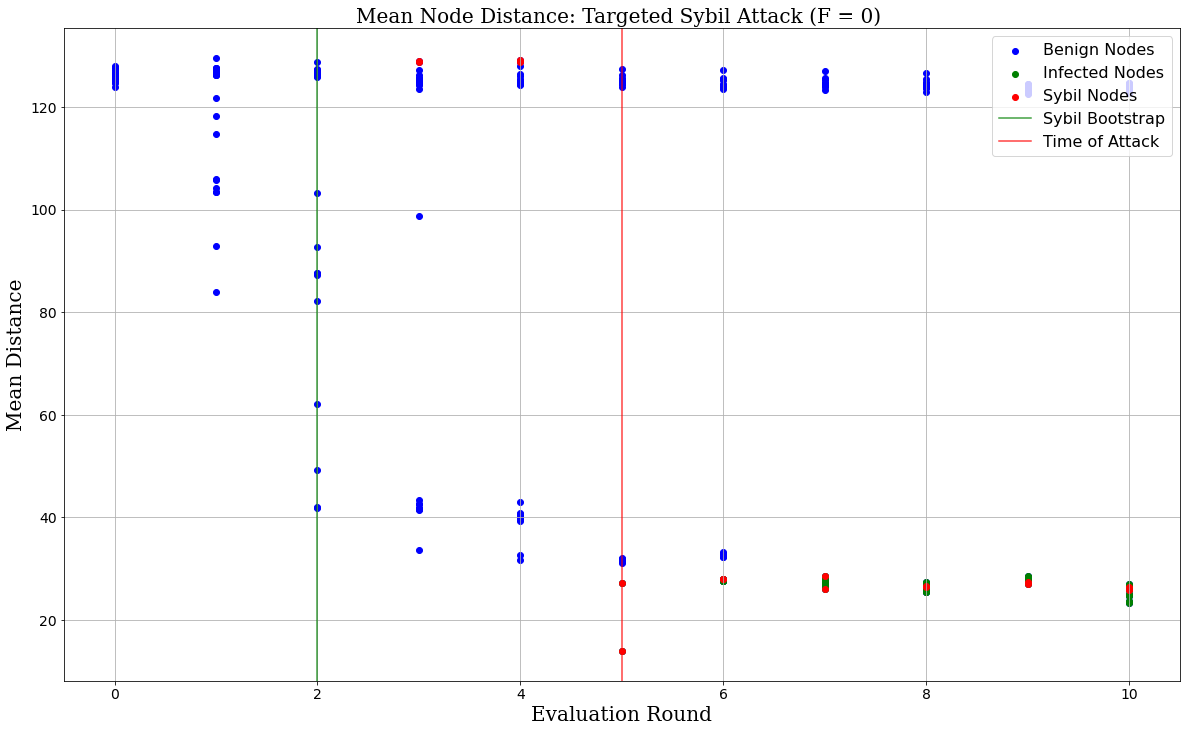

In [76]:
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111)

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 20,
        }



# Get all values to plot in the scatter
to_plot = []
for i in df_distances.index:
    for j in df_distances.iloc[i]:
        to_plot.append([i, j])
        
        
indices = [to_plot[i][0] for i in range(len(to_plot))]
values = [to_plot[i][1] for i in range(len(to_plot))]

df_distances_infected = df_distances.copy()

# Find out which values are of infected nodes
for i in df_distances_infected.index:
    for j in df_distances_infected.columns:
        if round_infected.iloc[j] == i:
            df_distances_infected.iloc[i][j] = -df_distances_infected.iloc[i][j]
        
        if df_distances_infected.iloc[i-1][j] < 0:
            df_distances_infected.iloc[i][j] = -df_distances_infected.iloc[i][j]

to_plot_green = []

# Create the list of indices and values to plot (since plt.scatter sucks)
for i in df_distances_infected.index:
    for j in df_distances_infected.columns:
        if (df_distances_infected.iloc[i][j] > 0):
            to_plot_green.append([i, None])
        elif (df_distances_infected.iloc[i][j] < 0):
            to_plot_green.append([i, -df_distances_infected.iloc[i][j]])
        else:
            to_plot_green.append([i, None])
            
indices_green = [to_plot_green[i][0] for i in range(len(to_plot_green))]
values_green = [to_plot_green[i][1] for i in range(len(to_plot_green))]


to_plot_red = []

df_distances_malicious = df_distances.copy()
### Find the malicious modes and make them red
for i in df_distances_malicious.index:
    for j in df_distances_malicious.columns:
        if (j >= num_nodes) and (df_distances_malicious.iloc[i][j] > 0):
            to_plot_red.append([i, df_distances_malicious.iloc[i][j]])
        elif (j >= num_nodes) and (df_distances_malicious.iloc[i][j] < 0):
            to_plot_red.append([i, -df_distances_malicious.iloc[i][j]])
        else:
            to_plot_red.append([i, None])

            
indices_red = [to_plot_red[i][0] for i in range(len(to_plot_red))]
values_red = [to_plot_red[i][1] for i in range(len(to_plot_red))]


ax.yaxis.set_label_position("left")


plt.title('Mean Node Distance: ' + str(model_title) + ' (' + str(F_title) + ') ', fontdict=font)

plt.xlabel('Evaluation Round', fontdict=font)
plt.ylabel('Mean Distance', fontdict=font)

plt.grid()

bootstrap_loc = (int)(join_time / MEASURE_RATE)
attack_loc = (int)(attack_time / MEASURE_RATE)



avg = pd.Series([np.mean(df_distances.iloc[x]) for x in df_distances.index])
median = pd.Series([np.median(df_distances.iloc[x]) for x in df_distances.index])


plt.scatter(indices, values, color='b', label='Benign Nodes')

if any(x is not None for x in values_green):
    plt.scatter(indices_green, values_green, color='g', label='Infected Nodes')
if any(x is not None for x in values_red):
    plt.scatter(indices_red, values_red, color='r', label='Sybil Nodes')
    plt.axvline(x = bootstrap_loc, color = 'g', alpha=0.75, label = 'Sybil Bootstrap')
    plt.axvline(x = attack_loc, color = 'r', alpha=0.75, label = 'Time of Attack')
    
# plt.plot(avg, color='black', label='Overall Mean Distance')


ax.tick_params(axis='both', which='major', labelsize=14)

plt.legend(loc='upper right', prop={'size': 16})



# Figures

Load the figures from past experiments

In [ ]:
sim_title = '2023-01-21_10h05m_F0__push__100_'
df_distances = pd.read_csv('C:/Users/awrg/Documents/Delft/Thesis/LTR/Results/FINAL/Datasets/' + sim_title + 'df_distances.csv').drop('Unnamed: 0', axis=1, inplace=False)
round_infected = pd.read_csv('C:/Users/awrg/Documents/Delft/Thesis/LTR/Results/FINAL/Datasets/' + sim_title + 'round_infected.csv').drop('Unnamed: 0', axis=1, inplace=False)

# df_distances = pd.read_csv(datasets_loc + sim_title + 'df_distances.csv').drop('Unnamed: 0', axis=1, inplace=False)
df_distances.columns = [(int)(x) for x in df_distances.columns]
# round_infected = pd.read_csv(datasets_loc + sim_title + 'round_infected.csv').drop('Unnamed: 0', axis=1, inplace=False)
round_infected.columns = [(int)(x) for x in round_infected.columns]


if 'targ' in sim_title:
    plot_model_title = ' Targeted Sybil Attack '
if 'infl' in sim_title:
    plot_model_title = ' Clicklog Inflation Attack '
if 'base' in sim_title:
    plot_model_title = ' Baseline '
if 'push' in sim_title:
    plot_model_title = ' Push vs. Pull '
if 'epic' in sim_title:
    plot_model_title = ' Epic Sybil Attack '

if 'F0' in sim_title:
    plot_F_title = ' (F = 0) '
if 'F1' in sim_title:
    plot_F_title = ' (F = 1) '
    


In [ ]:
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111)

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 36,
        }

# Get all values to plot in the scatter
to_plot = []
for i in df_distances.index:
    for j in df_distances.iloc[i]:
        to_plot.append([i, j])
        
        
indices = [to_plot[i][0] for i in range(len(to_plot))]
values = [to_plot[i][1] for i in range(len(to_plot))]



df_distances_infected = df_distances.copy()
# df_distances_infected = df_distances[:num_nodes].copy()


# Find out which values are of infected nodes
for i in df_distances_infected.index:
    for j in df_distances_infected.columns[:-2]:
        if round_infected.iloc[j].values[0] == i:
            df_distances_infected.iloc[i][j] = -df_distances_infected.iloc[i][j]
        
        if df_distances_infected.iloc[i-1][j] < 0:
            df_distances_infected.iloc[i][j] = -df_distances_infected.iloc[i][j]

to_plot_green = []

# Create the list of indices and values to plot (since plt.scatter sucks)
for i in df_distances_infected.index:
    for j in df_distances_infected.columns:
        if (df_distances_infected.iloc[i][j] > 0):
            to_plot_green.append([i, None])
        elif (df_distances_infected.iloc[i][j] < 0):
            to_plot_green.append([i, -df_distances_infected.iloc[i][j]])
        else:
            to_plot_green.append([i, None])
            
indices_green = [to_plot_green[i][0] for i in range(len(to_plot_green))]
values_green = [to_plot_green[i][1] for i in range(len(to_plot_green))]


to_plot_red = []

df_distances_malicious = df_distances.copy()

### Find the malicious modes and make them red
for i in df_distances_malicious.index:
    for j in df_distances_malicious[num_nodes:].columns:
        if (j >= num_nodes) and (df_distances_malicious.iloc[i][j] > 0):
            to_plot_red.append([i, df_distances_malicious.iloc[i][j]])
        elif (j >= num_nodes) and (df_distances_malicious.iloc[i][j] < 0):
            to_plot_red.append([i, -df_distances_malicious.iloc[i][j]])
        else:
            to_plot_red.append([i, None])

            
indices_red = [to_plot_red[i][0] for i in range(len(to_plot_red))]
values_red = [to_plot_red[i][1] for i in range(len(to_plot_red))]


ax.yaxis.set_label_position("left")


plt.title('Mean Node Distance:' + plot_model_title + plot_F_title + '(TEMP)', fontdict=font)
plt.title('Mean Node Distance:' + plot_model_title + plot_F_title, fontdict=font)

# plt.title(str(sim_title) + ': Mean Node Distance', fontdict=font)




plt.xlabel('Evaluation Round', fontdict=font)
plt.ylabel('Mean Distance', fontdict=font)

plt.grid()

bootstrap_loc = 25
attack_loc = 50



avg = pd.Series([np.mean(df_distances.iloc[x]) for x in df_distances.index])
median = pd.Series([np.median(df_distances.iloc[x]) for x in df_distances.index])


plt.scatter(indices, values, color='b', label='Benign Nodes', s=75)

if any(x is not None for x in values_red):
    plt.scatter(indices_red, values_red, color='r', label='Sybil Nodes', s=100)
    plt.scatter(indices_green, values_green, color='g', label='Infected Nodes', s=50)
    
    plt.axvline(x = bootstrap_loc, color = 'g', alpha=0.75, label = 'Sybil Bootstrap')
    plt.axvline(x = attack_loc, color = 'r', alpha=0.75, label = 'Time of Attack')
    
# if any(x is not None for x in values_green):
#     plt.scatter(indices_green, values_green, color='g', label='Infected Nodes', s=75)

    
# plt.plot(avg, color='black', label='Overall Mean Distance')


ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(labeltop=False, labelright=True)

lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=20)

# plt.legend(loc='upper right', prop={'size': 20})

lgnd.legendHandles[0]._sizes = [100]

if 'baseline' not in sim_title:
    lgnd.legendHandles[1]._sizes = [100]
    lgnd.legendHandles[2]._sizes = [100]




# Average Gossip Message Size

In [ ]:
fig = plt.figure(figsize=(20,12))


font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 30,
        }

ax = fig.add_subplot(111)


df_avg = pd.read_csv(datasets_loc + 'avg_gossip_message_size_ALL.csv').drop('Unnamed: 0', axis=1, inplace=False)

df_avg = df_avg/1000

minimum = [np.min(x) for x in [df_avg.iloc[y] for y in df_avg.index]]
maximum = [np.max(x) for x in [df_avg.iloc[y] for y in df_avg.index]]

plt.title('Mean Gossip Message Size (kB) - All Simulations', fontdict=font)
plt.xlabel('Evaluation Round', fontdict=font)
plt.ylabel('Size (kB)', fontdict=font)


# plt.plot(df_avg.baseline, linewidth=2, label='Gossip Message Size (Baseline)')
# plt.plot(df_avg.inflation, linewidth=2, label='Clicklog Inflation Attack')

# plt.plot(df_avg.targ, linewidth=2, label='Targeted Sybil Attack')
# plt.plot(df_avg.epic, linewidth=2, label='Epic Sybil Attack')
# plt.plot(df_avg.push, linewidth=2, label='Push vs. Pull')


# plt.plot(maximum, linewidth=2, label='Max')
# plt.plot(minimum, linewidth=2, label='Min')


overall_average = pd.Series([np.mean(x) for x in [df_avg.iloc[y] for y in df_avg.index]])
plt.plot(overall_average, label='Mean Message Size (all simulations)')

ax.fill_between(df_avg.index, minimum, maximum, alpha=0.2, label = 'Overall Message Size Range')


plt.grid()

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(labeltop=False, labelright=True)


plt.legend(loc='lower right', prop={'size':16})




plt.show()

In [ ]:
tag_popularity

In [ ]:
# The average number of nodes containing the most popular song for each query_term:
# X is number of gossip targets
# Y is average of (num_nodes_containing)


tag_popularity_loaded = pd.read_csv(datasets_loc + '2023-01-22_07h40m_F1__baseline__100_tag_popularity.csv')

    

fig = go.Figure()

fig.add_trace(go.Bar(x = tag_popularity_loaded['tag'],
                     y = tag_popularity_loaded['num_nodes_containing_round_100'], 
                     name = 'After 100 Rounds'))

fig.add_trace(go.Bar(x = tag_popularity_loaded['tag'],
                     y = tag_popularity_loaded['num_nodes_containing_round_50'], 
                     name = 'After 50 Rounds'))

fig.add_trace(go.Bar(x = tag_popularity_loaded['tag'],
                     y = tag_popularity_loaded['num_nodes_containing_round_25'], 
                     name = 'After 25 Rounds'))

fig.add_trace(go.Bar(x = tag_popularity_loaded['tag'],
                     y = tag_popularity_loaded['num_nodes_containing_round_5'], 
                     name = 'After 5 Rounds'))

fig.add_trace(go.Bar(x = tag_popularity_loaded['tag'],
                     y = tag_popularity_loaded['num_nodes_containing_round_1'], 
                     name = 'After 1 Round'))

fig.add_trace(go.Bar(x = tag_popularity_loaded['tag'],
                     y = tag_popularity_loaded['num_nodes_containing_round_0'], 
                     name = 'After 0 Rounds'))


fig.update_xaxes(tickangle=45)
fig.update_yaxes(
    range=(0, 100),
    constrain='domain'
)

fig.update_layout(title = {'text':"% Queries Containing Most Popular Song For Each Term - Baseline", 'y':0.9, 'x':0.45, 'xanchor':'center', 'yanchor':'top'},
                  barmode = 'overlay', 
                  title_font_size = 22,
                  width = 1000, 
                  height = 600
                 )



fig.show()

In [ ]:
baseline_f0_meds = pd.read_csv(datasets_loc + '2023-01-22_23h03m_F0__baseline__100_df_clicklog_medians.csv').drop('Unnamed: 0', axis=1, inplace=False)
baseline_f0_meds.columns = [(int)(x) for x in baseline_f0_meds.columns]

baseline_f1_meds = pd.read_csv(datasets_loc + '2023-01-22_07h40m_F1__baseline__100_df_clicklog_medians.csv').drop('Unnamed: 0', axis=1, inplace=False)
baseline_f1_meds.columns = [(int)(x) for x in baseline_f1_meds.columns]


targ_f0_meds = pd.read_csv(datasets_loc + '2023-01-23_02h36m_F0__targ_sybil__100_df_clicklog_medians.csv').drop('Unnamed: 0', axis=1, inplace=False)
targ_f0_meds.columns = [(int)(x) for x in targ_f0_meds.columns]

targ_f1_meds = pd.read_csv(datasets_loc + '2023-01-23_06h37m_F1__targ_sybil__100_df_clicklog_medians.csv').drop('Unnamed: 0', axis=1, inplace=False)
targ_f1_meds.columns = [(int)(x) for x in targ_f1_meds.columns]


inflation_f0_meds = pd.read_csv(datasets_loc + '2023-01-22_19h17m_F0__clicklog_inflation__100_df_clicklog_medians.csv').drop('Unnamed: 0', axis=1, inplace=False)
inflation_f0_meds.columns = [(int)(x) for x in inflation_f0_meds.columns]

inflation_f1_meds = pd.read_csv(datasets_loc + '2023-01-22_20h28m_F1__clicklog_inflation__100_df_clicklog_medians.csv').drop('Unnamed: 0', axis=1, inplace=False)
inflation_f1_meds.columns = [(int)(x) for x in inflation_f1_meds.columns]


epic_f0_meds = pd.read_csv(datasets_loc + '2023-01-23_15h42m_F0__epic_sybil__100_df_clicklog_medians.csv').drop('Unnamed: 0', axis=1, inplace=False)
epic_f0_meds.columns = [(int)(x) for x in epic_f0_meds.columns]

epic_f1_meds = pd.read_csv(datasets_loc + '2023-01-23_14h24m_F1__epic_sybil__100_df_clicklog_medians.csv').drop('Unnamed: 0', axis=1, inplace=False)
epic_f1_meds.columns = [(int)(x) for x in epic_f1_meds.columns]



push_f0_meds = pd.read_csv(datasets_loc + '2023-01-21_10h05m_F0__push__100_df_clicklog_medians.csv').drop('Unnamed: 0', axis=1, inplace=False)
push_f0_meds.columns = [(int)(x) for x in push_f0_meds.columns]

push_f1_meds = pd.read_csv(datasets_loc + '2023-01-22_00h25m_F1__push__100_df_clicklog_medians.csv').drop('Unnamed: 0', axis=1, inplace=False)
push_f1_meds.columns = [(int)(x) for x in push_f1_meds.columns]

In [ ]:
df_clicklog_medians = pd.DataFrame()

df_clicklog_medians['baseline_f0'] = baseline_f0_meds
df_clicklog_medians['baseline_f1'] = baseline_f1_meds

df_clicklog_medians['targ_f0'] = targ_f0_meds
df_clicklog_medians['targ_f1'] = targ_f1_meds

df_clicklog_medians['inflation_f0'] = inflation_f0_meds
df_clicklog_medians['inflation_f1'] = inflation_f1_meds

df_clicklog_medians['epic_f0'] = epic_f0_meds
df_clicklog_medians['epic_f1'] = epic_f1_meds

df_clicklog_medians['push_f0'] = push_f0_meds
df_clicklog_medians['push_f1'] = push_f1_meds


df_clicklog_medians = df_clicklog_medians * 100
df_clicklog_medians


In [ ]:
fig = plt.figure(figsize=(20,12))


font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 30,
        }

ax = fig.add_subplot(111)



plt.title('Median % Queries Containing Top Song - All Simulations', fontdict=font)
plt.xlabel('Evaluation Round', fontdict=font)
plt.ylabel('% Queries', fontdict=font)


plt.plot(df_clicklog_medians.baseline_f0, color='black', label = 'Baseline (F=0)')
plt.plot(df_clicklog_medians.baseline_f1, color='grey', label = 'Baseline (F=1)')

plt.plot(df_clicklog_medians.targ_f0, color='darkred', label = 'Targeted Sybil (F=0)')
plt.plot(df_clicklog_medians.targ_f1, color='red', label = 'Targeted Sybil (F=1)')

plt.plot(df_clicklog_medians.inflation_f0, color='darkgreen', label = 'Clicklog Inflation (F=0)')
plt.plot(df_clicklog_medians.inflation_f1, color='lime', label = 'Clicklog Inflation (F=1)')

plt.plot(df_clicklog_medians.epic_f0, color='darkorange', label = 'Epic Sybil (F=0)')
plt.plot(df_clicklog_medians.epic_f1, color='yellow', label = 'Epic Sybil (F=1)')

plt.plot(df_clicklog_medians.push_f0, color='purple', label = 'Push vs. Pull (F=0)')
plt.plot(df_clicklog_medians.push_f1, color='violet', label = 'Push vs. Pull (F=1)')

# plt.plot(overall_average, label='Overall Mean Message Size')

# ax.fill_between(df_avg.index, minimum, maximum, alpha=0.2, label = 'Overall Message Size Range')


plt.grid()
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(labeltop=False, labelright=True)


plt.legend(loc='lower right', prop={'size':16})




plt.show()




To find similarity score between nodes $n_i$ and $n_j$, find the following:

- $\kappa_{t} = |Q^{T}_i \cap Q^{T}_j|  %\hspace{10mm}  \textit{(size of matching query terms)}$
- $\kappa_{m} = |C_i(Q) \cap C_j(Q)| %\hspace{10mm} \textit{(size of matching query-click pairs)}$
- $\kappa_{u} = |C_i(Q) \cup C_j(Q)| %\hspace{10mm} \textit{(union of all queries)}$


$ \rightarrow  S_{i}(n_j) = \frac{\kappa_{t} + (\kappa_{m})^{2}}{\kappa_{u}} $

$$R_{i}(Q) = (\forall k \in K_Q), \hspace{2mm}  \sum_{j=0}^{N} (C_k \cdot (S_{i}(n_j) + F))$$

where:

- $S_i(n_j)$ indicates the similarity score for each node pair $(n_i, n_j) \in N$
- $C_k$ indicates the number of clicks associated with item $k \in K_Q$
- $K_Q$ is the unsorted set of results for query $Q$